## Import Libraries

Code reference from langchain academy course

In [75]:
from typing_extensions import TypedDict
from typing import Literal, Annotated, Any, Dict, List, Optional
from trustcall import create_extractor

from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage, trim_messages, convert_to_messages, get_buffer_string, merge_message_runs
from langchain_core.runnables.config import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import interrupt, Send
from langgraph.graph.message import add_messages
from langgraph.store.memory import InMemoryStore, BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.pregel.remote import RemoteGraph
from langgraph_sdk import get_client

import sqlite3
import random
import uuid
import httpx
import asyncio
from operator import add
from dataclasses import dataclass
from datetime import datetime
from IPython.display import display, Image, Markdown
from dotenv import load_dotenv
from pydantic import BaseModel, validator, ValidationError, Field

load_dotenv(override=True)

True

# Intro

## Simple Graph

### State

State are structured data flowing between edges
Nodes are function that process and change state

In [ ]:
class State(TypedDict):
    graph_state: str

In [ ]:
def node1(state: State) -> str:
    print("=== Node 1 ===")
    return {"graph_state": state['graph_state'] + " I invest in"}

def node2(state: State) -> str:
    print("=== Node 2 ===")
    return {"graph_state": state['graph_state'] + " Stocks"}

def node3(state: State) -> str:
    print("=== Node 3 ===")
    return {"graph_state": state['graph_state'] + " Crypto"}

### Edge

Connecting state

In [ ]:
# Conditional edge

def decide_investment(state: State) -> Literal["node2", "node3"]:
    print("=== Decision Node ===")
    
    input = state['graph_state']
    
    if random.random() < 0.5:
        return "node2"
    else:
        return "node3"

### Graph

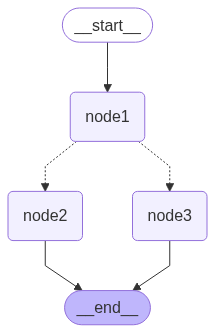

In [ ]:
# Define the graph
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Set entrypoint
# builder.set_entry_point("node1")

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_investment)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"graph_state": "Hello, "})

=== Node 1 ===
=== Decision Node ===
=== Node 3 ===


{'graph_state': 'Hello,  I invest in Crypto'}

## Chain

### Messages

In [ ]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model"),
    HumanMessage(content="Yes, that's right", name="Human"),
    AIMessage(content="Nice, what would you like to learn", name="Model"),
    HumanMessage(content="I would like to learn about financial statement", name="Human"),   
]

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement


### Chat Models

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
print(result.content)

Financial statements are crucial for understanding a company's financial health and making informed investment decisions. Here are the three primary financial statements you should be familiar with:

1. **Income Statement**: 
   - Also known as the profit and loss statement, it summarizes a company's revenues and expenses over a specific period, usually a quarter or a year.
   - Key components:
     - **Revenue**: The total income generated from sales of goods or services.
     - **Cost of Goods Sold (COGS)**: The direct costs attributable to the production of the goods sold by the company.
     - **Gross Profit**: Revenue minus COGS.
     - **Operating Expenses**: Costs required to run the business (such as selling, general, and administrative expenses).
     - **Net Income**: The profit after all expenses, taxes, and costs have been deducted from total revenue.

2. **Balance Sheet**: 
   - A snapshot of a company's financial position at a specific point in time, detailing assets, lia

In [ ]:
result.response_metadata

{'token_usage': {'completion_tokens': 541,
  'prompt_tokens': 54,
  'total_tokens': 595,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_51db84afab',
 'id': 'chatcmpl-C8ILNZYubVGo9zLQTmvZHVQ3NkHBf',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

In [ ]:
# Simple tool function
def multiply(a: int, b: int) -> int:
    return a * b

llm_tool = llm.bind_tools([multiply])

In [ ]:
tool_call = llm_tool.invoke([HumanMessage(content="What is 50 x 12?")])

In [ ]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'function': {'arguments': '{"a":50,"b":12}', 'name': 'multiply'},
  'type': 'function'}]

In [ ]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 50, 'b': 12},
  'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'type': 'tool_call'}]

### MessagesState + MemorySaver checkpoint

In [ ]:
# Example add_messages with langgraph.graph.messages
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e278be8e-e4a8-48a5-bc93-48e12712f88d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='8c3d28f0-73e1-402b-aff1-71dd2b38242e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6882c5b8-e92a-4158-8039-1c48ec52d96c')]

In [ ]:
class MessageState(MessagesState):
    pass

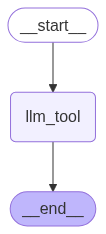

In [ ]:
memory = MemorySaver()

def tooling_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

builder = StateGraph(MessageState)
builder.add_node("llm_tool", tooling_llm)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "BangDer"}}

In [ ]:
message = graph.invoke({"messages": [HumanMessage(content="Hello")]}, config=config)

In [ ]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?


In [ ]:
message = graph.invoke({"messages": [HumanMessage(content="What is Jakarta most visited mall")]}, config=config)

In [ ]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


In [ ]:
state = graph.get_state(config=config)
for message in state.values['messages']:
    print(message.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


## Router

In [ ]:
class MessageState(MessagesState):
    pass

def multiply(a: int, b: int) -> int:
    """Multiply a and b"""
    return a * b

llm = ChatOpenAI(model="gpt-4o-mini")
llm_tool = llm.bind_tools([multiply])

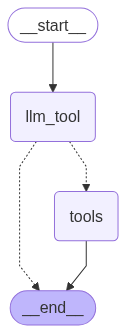

In [ ]:
def tool_with_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

memory = MemorySaver()
builder = StateGraph(MessageState)
builder.add_node("llm_tool", tool_with_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "User2"}}

In [ ]:
messages = [HumanMessage(content="What is 50 x 12?")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
messages = [HumanMessage(content="Explain multiplier for 5 years kids")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
for m in result['messages']:
    print(m.content) 

What is 50 x 12?

600
Explain multiplier for 5 years kids
A multiplier is like a magic number that helps us add the same number many times. 

Imagine you have 5 groups of 2 apples. Instead of counting each apple one by one, you can use a multiplier to make it faster. If you say "2 apples" and then "5 groups," you can find out how many apples there are in total by multiplying:

- So, 2 apples in each group × 5 groups = 10 apples.

This way, multiplying helps us find big numbers quickly without counting everything one by one!


## Agent

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

In [ ]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")
def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}

The main idea of agent is we can node back to assistant node to process next tool if needed

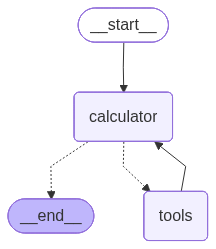

In [ ]:
memory = MemorySaver()

builder = StateGraph(MessagesState)
builder.add_node("calculator", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "calculator")
builder.add_conditional_edges("calculator", tools_condition)
builder.add_edge("tools", "calculator")
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "User3"}}
messages = [HumanMessage(content="Add 10 and 50 then multiply with 5 then divide with 2")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

In [ ]:
messages = [HumanMessage(content="Give me some fact based on that number")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

## Deployment

In [ ]:
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistant = await client.assistants.search()
assistant

[{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-08-26T09:51:25.429747+00:00',
  'updated_at': '2025-08-26T09:51:25.429747+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'router',
  'created_at': '2025-08-26T09:51:25.402920+00:00',
  'updated_at': '2025-08-26T09:51:25.402920+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '28d99cab-ad6c-5342-aee5-400bd8dc9b8b',
  'graph_id': 'simple_graph',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'simple_graph',
  'created_at': '2025-08-26T09:51:24.294212+00:00',
  'updated_at': '2025-08-26T09:51:24.294212+00:00',
  'version': 1,
  'description': None}]

In [ ]:
# We create a thread for tracking the state of our run
thread = await client.threads.create()

# Define the agent
agent = assistant[0]

In [ ]:
input = {"messages": [HumanMessage(content="Add 5 and 50 then multiply by 3")]}

# Stream
async for chunk in client.runs.stream(
        thread['thread_id'],
        agent["assistant_id"],
        input=input,
        stream_mode="values",
    ):
    if chunk.data and chunk.event != "metadata":
        print(chunk.data['messages'][-1]['content'])

Add 5 and 50 then multiply by 3

165
The result of adding \(5\) and \(50\) is \(55\), and then multiplying that by \(3\) results in \(165\).


# State and Memory

## State Schema

### Typed Dict

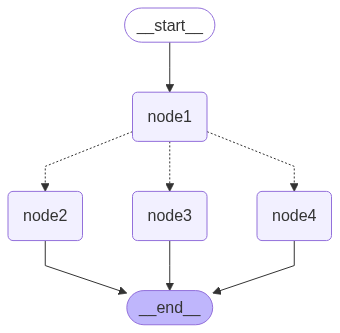

In [ ]:
class TypedState(TypedDict):
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"]
    
def node1(state: TypedState):
    print("===Node 1===")
    return {"name": state['name']}

def node2(state: TypedState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: TypedState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: TypedState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: TypedState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(TypedState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"name": "Bangder"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Stock'}

### Dataclass

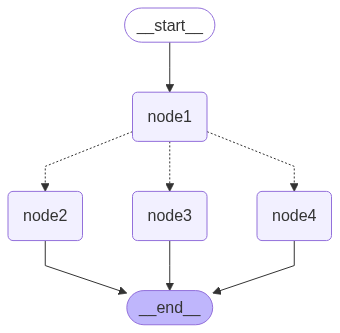

In [ ]:
@dataclass
class ClassState:
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"] = "Stock"

def node1(state: ClassState):
    print("===Node 1===")
    return {"name": state.name}

def node2(state: ClassState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: ClassState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: ClassState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: ClassState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(ClassState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"name": "Bangder", "asset": "Any"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Stock'}

Dataclass provide type hint but they dont enforce type

### Pydantic

In [ ]:
class PydanticState(BaseModel):
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"] = "Stock"
    
    @validator("asset")
    def validate_asset(cls, val):
       if val not in ["Stock", "Bonds", "Crypto"]:
           raise ValueError("Asset must be Stock, Bonds, or Crypto") 
       return val
   
try:
    state = PydanticState(name="Bangder", asset="Any")
except Exception as e:
    print("Error: ",e)

Error:  1 validation error for PydanticState
asset
  unexpected value; permitted: 'Stock', 'Bonds', 'Crypto' (type=value_error.const; given=Any; permitted=('Stock', 'Bonds', 'Crypto'))


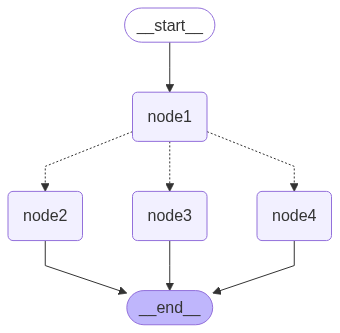

In [ ]:
def node1(state: PydanticState):
    print("===Node 1===")
    return {"name": state.name}

def node2(state: PydanticState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: PydanticState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: PydanticState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: PydanticState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(PydanticState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"name": "Bangder", "asset": "Stock"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Bonds'}

## State Reducer

When a node branch into > 1 node and run in parallel, which means they run in the same step of graph, they both attempt to overwrite the state on the same step, this is why state reducer came

### Reducer

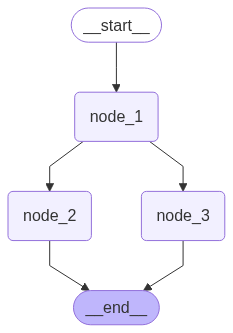

In [ ]:
# Example Branching graph
class ReducerState(TypedDict):
    counter: Annotated[list[int], add]
    
def node_1(state: ReducerState):
    print("---Node 1---")
    return {"counter": [state['counter'][-1] + 1]}

def node_2(state: ReducerState):
    print("---Node 2---")
    return {"counter": [state['counter'][-1] + 2]}

def node_3(state: ReducerState):
    print("---Node 3---")
    return {"counter": [state['counter'][-1] + 3]}


builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"counter": [1]})

---Node 1---
---Node 2---
---Node 3---


{'counter': [1, 2, 4, 5]}

In [ ]:
try:
    graph.invoke({"counter": None})
except Exception as e:
    print("Error: ",e)

Error:  can only concatenate list (not "NoneType") to list


Sometimes we need to input None to the node but it leave with error, so we have to make custom reducer instead of using add

### Custom Reducer

In [ ]:
def reduce_list(old_state: list | None, new_state: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        old_state (list | None): The first list to combine, or None.
        new_state (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not old_state:
        old_state = []
    if not new_state:
        new_state = []
    return old_state + new_state

class DefaultState(TypedDict):
    counter: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    counter: Annotated[list[int], reduce_list]
    messages: Annotated[list[str], reduce_list]

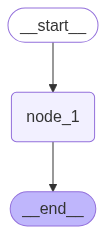

TypeError occurred: can only concatenate list (not "NoneType") to list


In [ ]:
def node_1(state: DefaultState):
    print("---Node 1---")
    return {"counter": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"counter" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

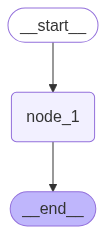

---Node 1---
{'counter': [2], 'messages': ['Bro', 'hi']}


In [ ]:
# Build graph
def node_1(state: CustomReducerState):
    print("---Node 1---")
    return {"counter": [2], "messages": ["hi"]}

builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"counter" : None, "messages": ["Bro"]}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

### Messages

In [ ]:
# Both work the same things, add_messages works as reducer for messages
class CustomMessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    key_1: str
    key_2: str
    
class ExtendedMessagesState(MessagesState):
    key_1: str
    key_2: str


In [ ]:
# add messages example
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on US Stock Market.", name="User")]

new_message = AIMessage(content="Sure, I can help with that. Which asset are you interested in?", name="Model")
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='2f3b1c40-f235-4cfd-bdd4-af2db7e16427'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='5107b1bd-6334-4fc7-99c6-608bea39f6a2'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='1c68186b-178f-4e65-84fb-791f2b2460a8')]

In [ ]:
# We also can overwrite the message with ID
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on US Stock.", name="User", id="2")]

# New message to add
new_message = HumanMessage(content="I'm looking for information on Indo Stockk", name="User", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on Indo Stockk", additional_kwargs={}, response_metadata={}, name='User', id='2')]

In [ ]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model", id="1"),
    HumanMessage(content="Yes, that's right", name="Human", id="2"),
    AIMessage(content="Nice, what would you like to learn", name="Model", id="3"),
    HumanMessage(content="I would like to learn about financial statement", name="Human", id="4"),
]

# Delete 2 recent message
delete_messages = [RemoveMessage(id = message.id) for message in messages[:-2]]

for m in messages:
    print(m)
    
print("\n")
print("====" * 40)
print("\n")

deleted_message = add_messages(messages, delete_messages)
for d in deleted_message:
    print(d)

content='Do you invest in Stock Market?' additional_kwargs={} response_metadata={} name='Model' id='1'
content="Yes, that's right" additional_kwargs={} response_metadata={} name='Human' id='2'
content='Nice, what would you like to learn' additional_kwargs={} response_metadata={} name='Model' id='3'
content='I would like to learn about financial statement' additional_kwargs={} response_metadata={} name='Human' id='4'




content='Nice, what would you like to learn' additional_kwargs={} response_metadata={} name='Model' id='3'
content='I would like to learn about financial statement' additional_kwargs={} response_metadata={} name='Human' id='4'


## Multiple Schemas

**Private State & Input Output Schema**

Somehow our data only accessible for some nodes (not for client side nor output node), think about internal nodes that pass information that isn't required in input / output nodes

Sometimes we also want to use different schemas for input and output

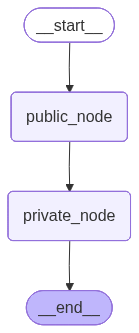

In [ ]:
# Private State

class PublicState(TypedDict):
    public_num: int
    
class PrivateState(TypedDict):
    _private_num: int
    
def public_node(state: PublicState) -> PrivateState:
    return {"_private_num": state["public_num"] * 2}

def private_node(state: PrivateState) -> PublicState:
    return {"public_num": state["_private_num"] + 1}

builder = StateGraph(PublicState)
builder.add_node("public_node", public_node)
builder.add_node("private_node", private_node)

builder.add_edge(START, "public_node")
builder.add_edge("public_node", "private_node")
builder.add_edge("private_node", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"public_num": 2})

{'public_num': 5}

Only public data expose outside graph, private num don't expose outsite graph unless we return it to public

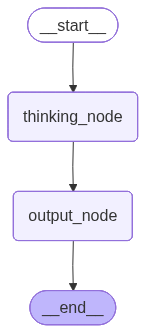

In [ ]:
class InputState(TypedDict):
    question: str
    
class OutputState(TypedDict):
    answer: str
    
class InternalState(TypedDict):
    question: str
    answer: str
    notes: str
    
def thinking_node(state: InputState) -> InternalState:
    return {"question": state["question"], "answer": "Hi, may i help you?", "notes": "... thinking"}

def output_node(state: InternalState) -> OutputState:
    return {"answer": state["answer"]}

builder = StateGraph(InternalState, input_schema=InputState, output_schema=OutputState)
builder.add_node("thinking_node", thinking_node)
builder.add_node("output_node", output_node)

builder.add_edge(START, "thinking_node")
builder.add_edge("thinking_node", "output_node")
builder.add_edge("output_node", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"question": "Hi, how are you?"})

{'answer': 'Hi, may i help you?'}

Here we can customize input and output format and protect the internal state from being expose

## Trim and Filter Messages

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

### Reducer

A challenge when working with messages is managing long conversation, which result in high token usage because we pass a growing list of messages to the model. This is why we need to filter our input messages

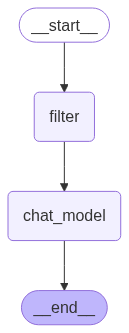

In [ ]:
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages (Reference from reducer)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model", id="1"),
    HumanMessage(content="Yes, that's right", name="Human", id="2"),
    AIMessage(content="Nice, what would you like to learn", name="Model", id="3"),
    HumanMessage(content="I would like to learn about financial statement", name="Human", id="4"),
]

result = graph.invoke({"messages": messages})
for message in result['messages']:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific point in time. It follows the accounting equation:
   \[
   \text{Assets} = \text{Liabilities} + \text{Equity}
   \]
   - **Assets** include anything of value that the company owns—cash, inventory, property, equipment, etc.
   - **Liabil

### Filtering Message

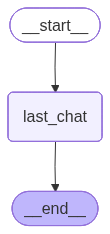

In [ ]:
def last_chat_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"][-1:])}

builder = StateGraph(MessagesState)
builder.add_node("last_chat", last_chat_node)
builder.add_edge(START, "last_chat")
builder.add_edge("last_chat", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages.append(result['messages'][-1])
messages.append(HumanMessage(content="Tell me more about Statement of changes in equity", name="Human"))

In [ ]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific 

In [ ]:
result = graph.invoke({"messages": messages})
for message in result['messages']:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific 

### Trimming messages

With trimming, we can set number of token needed

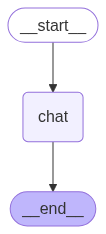

In [ ]:
def chat_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o"),
        allow_partial=False
    )
    return {"messages": llm.invoke(messages)}

builder = StateGraph(MessagesState)
builder.add_node("chat", chat_node)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages.append(result['messages'][-1])
messages.append(HumanMessage(content="What mistake do people usually did while analyze Income Statement"))
messages

[AIMessage(content='Do you invest in Stock Market?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="Yes, that's right", additional_kwargs={}, response_metadata={}, name='Human', id='2'),
 AIMessage(content='Nice, what would you like to learn', additional_kwargs={}, response_metadata={}, name='Model', id='3'),
 HumanMessage(content='I would like to learn about financial statement', additional_kwargs={}, response_metadata={}, name='Human', id='4'),
 AIMessage(content="Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:\n\n1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific point in time. It follows the accounting equation:\n   \\[\n   \\text{Asse

In [ ]:
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o"),
    allow_partial=False
)

[HumanMessage(content='What mistake do people usually did while analyze Income Statement', additional_kwargs={}, response_metadata={})]

In [ ]:
result = graph.invoke({"messages": messages})
for message in result['messages']:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific 

## Chatbot + Memory

We will create an chatbot agent which can summarize conversation if there are lots of message to save up tokens, after summarizing, we can delete previous message (it's like compress a lot of token messages)

In [ ]:
# Usecase for RAM memory, auto delete when program is finished or connection is closed
conn = sqlite3.connect(":memory:")

# Connect to local database
conn = sqlite3.connect("db/memory.db", check_same_thread=False)

# Checkpointer
memory = MemorySaver() # -> No database, purely using python dict
memory = SqliteSaver(conn)

In [ ]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class State(MessagesState):
    summary: str
    

def call_model(state: State):
    summary = state.get("summary", "")
    
    if summary:
        system_message = f"Summary from previous conversation : {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:   
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    """Summarize the conversation and delete previous messages only left 2 newest messages"""
    summary = state.get("summary", "")
    
    if summary: 
        # if summary exist we extend the conversation
        summary_message = (
            f"This is summary of previous conversation : {summary}\n"
            "Extend those summary with new messages below: "
        )
    else: 
        summary_message = "\nCreate summary of this conversation above: "
        
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    deleted_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": deleted_messages}

def should_summarize(state: State) -> Literal["summarize_conversation", END]: # type: ignore
    """When the message get longer (more than 4) it should summarize the conversation"""
    messages = state["messages"]

    if len(messages) > 4:
        return "summarize_conversation"
     
    return END

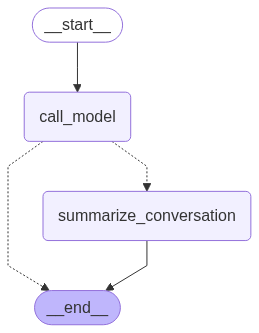

In [ ]:
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_summarize)
builder.add_edge("summarize_conversation", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "TestBot"}}

In [ ]:
input_message = HumanMessage(content="I want to learn about flow and orderbook analysis on stock")
response = graph.invoke({"messages": [input_message]}, config=config)

input_message = HumanMessage(content="Does those method has relationship with smart money concept?")
response = graph.invoke({"messages": [input_message]}, config=config)

for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

I want to learn about flow and orderbook analysis on stock
================================== Ai Message ==================================

Flow and order book analysis are important concepts in trading and investing, particularly in the context of stocks and other financial instruments. Here’s a breakdown of both concepts:

### Flow Analysis

**Flow analysis** refers to the study of the buying and selling activity in the market. It involves understanding the volume and direction of trades to gauge market sentiment and potential price movements. Here are some key components:

1. **Volume**: The number of shares traded over a specific period. High volume can indicate strong interest in a stock, while low volume may suggest a lack of interest.

2. **Order Flow**: This refers to the actual buy and sell orders that are being placed in the market. Analyzing order flow can help traders understand the intention

In [ ]:
graph.get_state(config = config).values.get("summary", "")

''

In [ ]:
input_message = HumanMessage(content="Do you think risk management is important?")
response = graph.invoke({"messages": [input_message]}, config=config)

In [ ]:
print(graph.get_state(config = config).values.get("summary", ""))

In this conversation, we discussed the concepts of flow and order book analysis in stock trading, highlighting their importance in understanding market dynamics and the behavior of "smart money" (institutional investors). Flow analysis involves studying buying and selling activity to gauge market sentiment, while order book analysis provides a real-time view of buy and sell orders, revealing liquidity and potential support/resistance levels.

We also explored the relationship between these analyses and smart money, emphasizing how traders can use flow and order book data to align their strategies with institutional investors. Additionally, we underscored the critical importance of risk management in trading and investing. Effective risk management helps preserve capital, maintain emotional control, ensure consistency, and adapt to market volatility. It involves techniques such as position sizing, setting stop-loss orders, and diversifying investments, all aimed at minimizing losses and

In [ ]:
graph.get_state(config = config)

StateSnapshot(values={'messages': [HumanMessage(content='Do you think risk management is important?', additional_kwargs={}, response_metadata={}, id='0e815ca3-bda6-4b00-a8f1-0cc74ee418fb'), AIMessage(content='Yes, risk management is critically important in trading and investing. It serves as a foundational element for long-term success in the financial markets. Here are several reasons why risk management is essential:\n\n### 1. **Preservation of Capital**\n   - The primary goal of risk management is to protect your capital. By implementing effective risk management strategies, you can minimize losses and ensure that you have enough capital to continue trading or investing over the long term.\n\n### 2. **Emotional Control**\n   - Trading can be emotionally taxing, especially during periods of high volatility. A solid risk management plan helps traders stick to their strategies and avoid making impulsive decisions based on fear or greed.\n\n### 3. **Consistency**\n   - Effective risk ma

# UX + Human in the Loop

## Streaming

Using chatbot graph

Notes:

There are 2 ways of streaming `.stream` and `.astream` are sync and async method for streaming result

Langgraph also support 2 streaming mode for state:
- `values`: return full state of the graph each time the node called
- `update`: update the state of the graph after each time the node called



![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

### Example .stream

In [ ]:
config = {"configurable": {"thread_id": "Streaming"}}

In [ ]:
input = HumanMessage(content="How do ETF works?")
for message in graph.stream({"messages": [input]}, config=config, stream_mode="updates"):
    print(message)

{'call_model': {'messages': AIMessage(content='Exchange-Traded Funds (ETFs) are investment funds that are traded on stock exchanges, similar to individual stocks. They are designed to track the performance of a specific index, commodity, currency, or a mix of various asset classes. Here’s how they work:\n\n### 1. Structure of ETFs\n- **Composition**: An ETF holds a collection of assets, such as stocks, bonds, or commodities. For example, a stock ETF might track the S&P 500 index by holding shares of the companies that make up that index.\n- **Shares**: Investors buy shares of the ETF, which represent a proportional ownership of the underlying assets.\n\n### 2. Trading\n- **Exchange-Traded**: ETFs are bought and sold on stock exchanges throughout the trading day, just like individual stocks. This allows for real-time pricing and liquidity.\n- **Market Price**: The price of an ETF share fluctuates throughout the day based on supply and demand, but it generally stays close to the net asse

In [ ]:
message["call_model"]['messages'].model_dump()

{'content': 'Exchange-Traded Funds (ETFs) are investment funds that are traded on stock exchanges, similar to individual stocks. They are designed to track the performance of a specific index, commodity, currency, or a mix of various asset classes. Here’s how they work:\n\n### 1. Structure of ETFs\n- **Composition**: An ETF holds a collection of assets, such as stocks, bonds, or commodities. For example, a stock ETF might track the S&P 500 index by holding shares of the companies that make up that index.\n- **Shares**: Investors buy shares of the ETF, which represent a proportional ownership of the underlying assets.\n\n### 2. Trading\n- **Exchange-Traded**: ETFs are bought and sold on stock exchanges throughout the trading day, just like individual stocks. This allows for real-time pricing and liquidity.\n- **Market Price**: The price of an ETF share fluctuates throughout the day based on supply and demand, but it generally stays close to the net asset value (NAV) of the underlying as

### Streaming Token

In [ ]:
config = {"configurable": {"thread_id": "Streaming_token"}}

In [ ]:
input_message = HumanMessage(content="Tell me about sesquehanna capital management")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: call_model. Type: on_chain_start. Name: call_model
Node: call_model. Type: on_chat_model_start. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model

In [ ]:
# To stream only the content
stream_node = "call_model"

input_message = HumanMessage(content="Tell me about goldman sachs")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get("langgraph_node", "") == stream_node:
        print(event['data']['chunk'].content, end="")

Goldman Sachs Group, Inc. is a leading global investment banking, securities, and investment management firm headquartered in New York City. Founded in 1869 by Marcus Goldman, the firm has established itself as one of the most influential financial institutions in the world.

### Key Areas of Business:

1. **Investment Banking**: Goldman Sachs provides advisory services for mergers and acquisitions (M&A), restructurings, and capital raising. The firm is known for its expertise in underwriting and facilitating complex financial transactions for corporations, governments, and institutions.

2. **Securities**: The firm engages in trading and market-making across various asset classes, including equities, fixed income, currencies, and commodities. Goldman Sachs plays a significant role in the global securities markets, providing liquidity and facilitating transactions.

3. **Investment Management**: Goldman Sachs offers a wide range of investment management services to institutional and in

### Langgraph API

In [ ]:
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

[{'assistant_id': '8a4ac7a4-50eb-5206-98cc-4a72345cb1f7',
  'graph_id': 'chatbot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot',
  'created_at': '2025-08-29T16:29:23.455873+00:00',
  'updated_at': '2025-08-29T16:29:23.455873+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-08-29T16:29:23.451011+00:00',
  'updated_at': '2025-08-29T16:29:23.451011+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'router',
  'created_at': '2025-08-29T16:29:23.429329+00:00',
  'updated_at': '2025-08-29T16:29:23.429329+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '28d99cab-ad6c-5342-aee5-

In [ ]:
thread = await client.threads.create()

# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '0198f6aa-5c73-726a-b0dd-bcd464c7cbe5', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a1f5d93c-93bb-4875-af27-b1f13d4cf45a', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a1f5d93c-93bb-4875-af27-b1f13d4cf45a', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_uwAnAAK5UXZpABa23q37s6Tt', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_

In [ ]:
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=====" * 10)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='141f742b-ec28-47c4-9b42-01d4946f0810'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 238, 'output_tokens': 17, 'total_tokens': 255, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_9lZe5xs1fM3C37fdCf1WMA1P', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 238, 'total_tokens': 255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C9whtuBN5sMDW2XIDqnMSdLxHhYFj', 'service_tier': 'default', 'finish_reason': 'tool_cal

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3 then add with 3 then divide by 2")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event)

StreamPart(event='metadata', data={'run_id': '0198f6de-4380-74b4-a667-649a57dfa392', 'attempt': 1})
StreamPart(event='messages/metadata', data={'run--77cbfeec-ff23-4e7a-a0da-cffb75897f9e': {'metadata': {'created_by': 'system', 'graph_id': 'agent', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'run_attempt': 1, 'langgraph_version': '0.6.6', 'langgraph_api_version': '0.3.0', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'http://127.0.0.1:2024', 'host': '127.0.0.1:2024', 'accept-encoding': 'gzip, deflate, br, zstd', 'connection': 'keep-alive', 'user-agent': 'langgraph-sdk-py/0.2.2', 'x-api-key': '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', 'content-length': '285', 'content-type': 'application/json', 'accept': 'text/event-stream', 'cache-control': 'no-store', 'x-request-id': '7140f6be-098c-4366-99e0-9e348f46c92d', 'langgraph_auth_user_id': '', 'langgraph_request_id': '7140f6be-098c-4366-99e0-9e348f46c92d', 'run_id': '0198f6de-4380-

We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

More docs [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages"):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 0198f6e7-cead-755c-82c4-dca6d34e2906
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

## Breakpoints

In [ ]:
def multiply(a: int | float, b: int | float) -> int | float:
    """Multiply a and b."""
    return a * b

# This will be a tool
def add(a: int | float, b: int | float) -> int | float:
    """Adds a and b."""
    return a + b

def divide(a: int | float, b: int | float) -> int | float:
    """Divide a by b."""
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_tools = llm.bind_tools(tools)

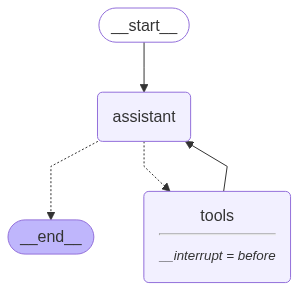

In [ ]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"] ,checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "breakpoint"}}

In [ ]:
human = HumanMessage(content="Multiply 2 and 3, then add the result with 5, then divide with 2")

for event in graph.stream({"messages": [human]}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3, then add the result with 5, then divide with 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KvNcrZEudad2jYDTbPZO6OXI)
 Call ID: call_KvNcrZEudad2jYDTbPZO6OXI
  Args:
    a: 2
    b: 3
  add (call_h388DPgCbHqs2DpiO6HTTgDY)
 Call ID: call_h388DPgCbHqs2DpiO6HTTgDY
  Args:
    a: 6
    b: 5
  divide (call_keE2SAYV3kbOG9pF7sZF68yv)
 Call ID: call_keE2SAYV3kbOG9pF7sZF68yv
  Args:
    a: 11
    b: 2


As we see, the graph stop in Ai message step and don't continue to next tools step which means the graph has been interupted

In [ ]:
state = graph.get_state(config)
print(state)
print("=====" * 20)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3 then add with 3 then divide by 2', additional_kwargs={}, response_metadata={}, id='ec7787a3-81da-4b43-8252-95de62843944'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_37lHkb3KgnnjsPPuRxqCEefL', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_OPR1Q2j0bToes80JvkY6LDsa', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 133, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-CAIGYA3Pwkvt57YwKT6Q0iAWu5ii6', 'service_tier': 'default', 'finish_reason': 't

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

In [ ]:
for event in graph.stream(None, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_KvNcrZEudad2jYDTbPZO6OXI)
 Call ID: call_KvNcrZEudad2jYDTbPZO6OXI
  Args:
    a: 2
    b: 3
  add (call_h388DPgCbHqs2DpiO6HTTgDY)
 Call ID: call_h388DPgCbHqs2DpiO6HTTgDY
  Args:
    a: 6
    b: 5
  divide (call_keE2SAYV3kbOG9pF7sZF68yv)
 Call ID: call_keE2SAYV3kbOG9pF7sZF68yv
  Args:
    a: 11
    b: 2
================================= Tool Message =================================
Name: divide

5.5
================================== Ai Message ==================================

Here's how the calculations unfold:

1. **Multiply 2 and 3**:
   \[
   2 \times 3 = 6
   \]

2. **Add the result to 5**:
   \[
   6 + 5 = 11
   \]

3. **Divide by 2**:
   \[
   \frac{11}{2} = 5.5
   \]

The final result is \(5.5\).


We can use user input to validate the graph should continue or not

In [ ]:
config = {"configurable": {"thread_id": "breakpoint2"}}

human = HumanMessage(content="Multiply 2 and 3, then add the result with 5, then divide with 2")
for event in graph.stream({"messages": [human]}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()
    
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, config=config, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3, then add the result with 5, then divide with 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_R4VPKbVC84z24vCIrkJNMP01)
 Call ID: call_R4VPKbVC84z24vCIrkJNMP01
  Args:
    a: 2
    b: 3
  add (call_arNBDmKgWwarC7rw1Lw1VCtu)
 Call ID: call_arNBDmKgWwarC7rw1Lw1VCtu
  Args:
    a: 6
    b: 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_R4VPKbVC84z24vCIrkJNMP01)
 Call ID: call_R4VPKbVC84z24vCIrkJNMP01
  Args:
    a: 2
    b: 3
  add (call_arNBDmKgWwarC7rw1Lw1VCtu)
 Call ID: call_arNBDmKgWwarC7rw1Lw1VCtu
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================
Tool Calls:
  divide (call_RbTGUrwfNXQBUmRPjTdlZi9y)
 Call ID: ca

In [ ]:
state = graph.get_state(config)

for message in state.values['messages']:
    print(message)

print("=====" * 20)
print(state.next)

content='Multiply 2 and 3, then add the result with 5, then divide with 2' additional_kwargs={} response_metadata={} id='12042e76-a448-4d41-95c1-4913a36970b7'
content='' additional_kwargs={'tool_calls': [{'id': 'call_R4VPKbVC84z24vCIrkJNMP01', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_arNBDmKgWwarC7rw1Lw1VCtu', 'function': {'arguments': '{"a": 6, "b": 5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 137, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-CAIXM0sl5Vs3b4nYx4G3OzFboEb7Y', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--1ad7c4ab-7b

### With langgraph API

In [ ]:
client = get_client(url="http://127.0.0.1:2024")
thread = await client.threads.create()
human = HumanMessage(content="Multiply 2 and 3, then add the result with 5, then divide with 2")
message_input = {"messages": [human]}

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input = message_input,
    stream_mode="values",
    interrupt_before=["tools"]
):
    print(f"Running event type: {chunk.event}")
    m = chunk.data.get("messages", [])
    if m:
        print(m[-1])
        print("=====" * 20)


Running event type: metadata
Running event type: values
{'content': 'Multiply 2 and 3, then add the result with 5, then divide with 2', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'c3f420f1-6b38-47a8-9781-2afb8d697a8c', 'example': False}
Running event type: values
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_11scV8NkOyJtu9x4WY5Q9mO4', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 148, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAJAbgnLMVyLDTosqP8JtUNxLJ2Zu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'lo

proceed the previous breakpoint by set the input with `None`

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input = None,
    stream_mode="values",
    interrupt_before=["tools"]
):
    print(f"Running event type: {chunk.event}")
    m = chunk.data.get("messages", [])
    if m:
        print(m[-1])
        print("=====" * 20)

Running event type: metadata
Running event type: values
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_sylXE53rAsP3aUjGuwXbpwQb', 'function': {'arguments': '{"a":11,"b":2}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 198, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAJB1u4TLy9eNKSD1RjnkXz2A4e97', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--a9681911-a397-422a-a4a5-5961ce21719d-0', 'example': False, 'tool_calls': [{'name': 'divide', 'args': {'a': 11, 'b': 2}, 'id': 'call_sylXE53rAsP3aUjGuwXbpwQb', 'type': 'tool_call'}], 'invalid_tool_c

## Editing State and Human Feedback

In [ ]:
def multiply(a: int | float, b: int | float) -> int | float:
    """Multiply a and b."""
    return a * b

# This will be a tool
def add(a: int | float, b: int | float) -> int | float:
    """Adds a and b."""
    return a + b

def divide(a: int | float, b: int | float) -> int | float:
    """Divide a by b."""
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

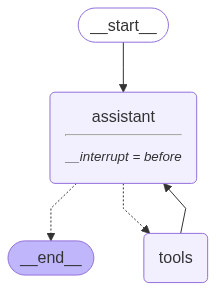

In [ ]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"] ,checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
message_input = {"messages": [HumanMessage(content="Multiply 5 and 10")]}
config = {"configurable": {"thread_id": "human1"}}

In [ ]:
for event in graph.stream(message_input, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 10


In [ ]:
state = graph.get_state(config)

In [ ]:
graph.update_state(config, {"messages": [HumanMessage(content="Actually, Divide 5 and 10")]})

{'configurable': {'thread_id': 'human1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0862f7-e622-68d6-8001-f9d409d9a301'}}

In [ ]:
new_state = graph.get_state(config).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 10
================================ Human Message =================================

Actually, Divide 5 and 10


In [ ]:
for event in graph.stream(None, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Actually, Divide 5 and 10
================================== Ai Message ==================================
Tool Calls:
  divide (call_I3Fbwzgi9YaFu65pXXjY7S1S)
 Call ID: call_I3Fbwzgi9YaFu65pXXjY7S1S
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: divide

0.5


In [ ]:
for event in graph.stream(None, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: divide

0.5
================================== Ai Message ==================================

The result of dividing 5 by 10 is 0.5.


### Langgraph API Studio

In [ ]:
client = get_client(url="http://127.0.0.1:2024")
thread = await client.threads.create()
message_input = {"messages": [HumanMessage(content="Multiply 5 and 10")]}

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=message_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 5 and 10', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'd6bb87df-2f0d-4cbb-8dd6-e612531666b8', 'example': False}
--------------------------------------------------


In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 5 and 10',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'd6bb87df-2f0d-4cbb-8dd6-e612531666b8',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'a7d512c7-b002-2fca-4eea-ab1dd28e3c42',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'host': '127.0.0.1:2024',
  'accept-encoding': 'gzip, deflate, br, zstd',
  'connection': 'keep-alive',
  'user-agent': 'langgraph-sdk-py/0.2.2',
  'x-api-key': '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',
  'content-length': '284',
  'content-type': 'application/json',
  'accept': 'text/event-stream',
  'cache-control': 'no-store',
  'x-request-id': '983a20e7-364c-4ebd-9e62-f21b35ac7d3d',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'l

In [ ]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 5 and 10',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'd6bb87df-2f0d-4cbb-8dd6-e612531666b8',
 'example': False}

In [ ]:
last_message['content'] = "Actually divide 5 and 10!"
last_message

{'content': 'Actually divide 5 and 10!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'd6bb87df-2f0d-4cbb-8dd6-e612531666b8',
 'example': False}

In [ ]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': 'baab0524-5246-4bc6-8dca-f3331b28c808',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08631a-3a03-6193-8001-552ea6914cf6'},
 'configurable': {'thread_id': 'baab0524-5246-4bc6-8dca-f3331b28c808',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08631a-3a03-6193-8001-552ea6914cf6'},
 'checkpoint_id': '1f08631a-3a03-6193-8001-552ea6914cf6'}

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '0.5', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'divide', 'id': '21213a6c-eae0-40bc-b40f-7c2b19458365', 'tool_call_id': 'call_REW2cCfT0mnIS0iyC3hqnhGT', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of dividing 5 by 10 is 0.5.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 16, 'prompt_tokens': 163, 'total_tokens': 179, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAVcl69MNYzTkyukRrtDzvlq6UsgQ', 'service_tier'

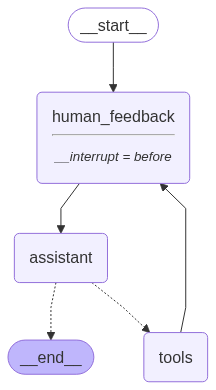

In [ ]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")

def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "human_feedback")
builder.add_edge("assistant", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"] ,checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
message_input = {"messages": [HumanMessage(content="Multiply 5 and 10")]}
config = {"configurable": {"thread_id": "human1"}}

for event in graph.stream(message_input, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_input = input("How would you like to update the state: ")

graph.update_state(config, {"messages": [HumanMessage(content=user_input)]}, as_node="human_feedback")

for event in graph.stream(None, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 10
================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  multiply (call_tDuETjRuXjLNPiDek1FP46pY)
 Call ID: call_tDuETjRuXjLNPiDek1FP46pY
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: multiply

50


## Dynamic Breakpoints

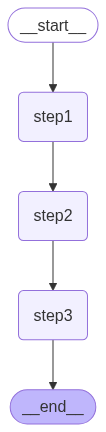

In [ ]:
class State(TypedDict):
    input: str
    
def step1(state: State) -> State:
    print("=== Node 1 ===")
    return state
    
def step2(state: State) -> State:
    
    if len(state["input"]) > 10:
        raise interrupt(f"Input must less than 10 words: {state['input']}")
    print("=== Node 2 ===")
    return state
    
def step3(state: State) -> State:
    print("=== Node 3 ===")
    return state

builder = StateGraph(State)
builder.add_node("step1", step1)
builder.add_node("step2", step2)
builder.add_node("step3", step3)
builder.add_edge(START, "step1")
builder.add_edge("step1", "step2")
builder.add_edge("step2", "step3")
builder.add_edge("step3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
message_input = {"input": "hello world"}
config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(message_input, config=config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
=== Node 1 ===
{'input': 'hello world'}


In [ ]:
state = graph.get_state(config)
print(state.next)
print(state.tasks)

('step2',)
(PregelTask(id='19b09ded-ba3c-4930-1f2c-3fa5a518c86c', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(Interrupt(value='Input must less than 10 words: hello world', id='c89b5e481d4ae7f2204e3833b866326f'),), state=None, result=None),)


In [ ]:
graph.update_state(config, {"input": "hello"})
state = graph.get_state(config)
print(state.next)
print(state.tasks)

('step2',)
(PregelTask(id='f7332687-d58e-d6bf-474c-7da09f650172', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),)


In [ ]:
for event in graph.stream(None, config, stream_mode="values"):
    print(event)

{'input': 'hello'}
=== Node 2 ===
{'input': 'hello'}
=== Node 3 ===
{'input': 'hello'}


In [ ]:
state = graph.get_state(config)
print(state.next)
print(state.tasks)

()
()


### Langgraph API 

In [ ]:
client = get_client(url="http://127.0.0.1:2024")
message_input = {"input": "hello world"}
thread = await client.threads.create()

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input = message_input,
    stream_mode="values"
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")
    

Receiving new event of type: metadata...
{'run_id': '0198ff4f-f6de-74c1-84ed-ad8d281fef9e', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'__interrupt__': [{'value': 'Received input that is longer than 5 characters: hello world', 'id': 'placeholder-id'}]}





In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
print(current_state['next'])
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

['step_2']


{'checkpoint': {'thread_id': '156a4576-17b7-4386-b869-766e37d7d423',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086481-19ac-6de3-8002-677e06cdca08'},
 'configurable': {'thread_id': '156a4576-17b7-4386-b869-766e37d7d423',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086481-19ac-6de3-8002-677e06cdca08'},
 'checkpoint_id': '1f086481-19ac-6de3-8002-677e06cdca08'}

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values"):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '0198ff55-c582-751d-b5f8-c0b49d570d47', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'host': '127.0.0.1:2024',
  'accept-encoding': 'gzip, deflate, br, zstd',
  'connection': 'keep-alive',
  'user-agent': 'langgraph-sdk-py/0.2.2',
  'x-api-key': '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',
  'content-length': '111',
  'content-type': 'application/json',
  'accept': 'text/event-stream',
  'cache-control': 'no-store',
  'x-request-id': '45360915-53a1-4047-a8fc-9c9b0c5a58c5',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '45360915-53a1-4047-a8fc-9c9b0c5a58c5',
  'graph_id': 'dynamic_breakpoints',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.6',
  'langgraph_api_version': '0.3.0',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '0198ff5

## Time Travel

In [ ]:
def multiply(a: int | float, b: int | float) -> int | float:
    """Multiply a and b."""
    return a * b

# This will be a tool
def add(a: int | float, b: int | float) -> int | float:
    """Adds a and b."""
    return a + b

def divide(a: int | float, b: int | float) -> int | float:
    """Divide a by b."""
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

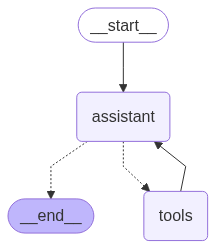

In [ ]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
message_input = {"messages": HumanMessage(content="Multiply 9 by 3")}
config = {"configurable": {"thread_id": "travel"}}

for event in graph.stream(message_input, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 9 by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_h8Q0KEZ49HWnSCgYxO16xcXA)
 Call ID: call_h8Q0KEZ49HWnSCgYxO16xcXA
  Args:
    a: 9
    b: 3
================================= Tool Message =================================
Name: multiply

27
================================== Ai Message ==================================

The result of multiplying 9 by 3 is 27.


### Browsing history

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

In [ ]:
# Look at our current state of our graph
graph.get_state(config).values

{'messages': [HumanMessage(content='Multiply 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h8Q0KEZ49HWnSCgYxO16xcXA', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 122, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-CAYn5cVZ1nljn3LPUgWhJ0rqTiqYu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b1dfd057-507f-4b9e-a650-5e87612c40c9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 9, 'b': 3}, 'id': 'call_h8Q0KEZ49HWnSCgYxO16xcXA', 

In [ ]:
all_state = [state for state in graph.get_state_history(config)]
all_state
# all_state[0].values['messages'][1].model_dump()

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h8Q0KEZ49HWnSCgYxO16xcXA', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 122, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-CAYn5cVZ1nljn3LPUgWhJ0rqTiqYu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b1dfd057-507f-4b9e-a650-5e87612c40c9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 9, 'b': 3}, 'id': 'call_h8Q0KEZ

### Replaying

We can view our previous state with checkpoint_id

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [ ]:
to_replay = all_state[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd')]}, next=('assistant',), config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f0864e1-cb11-6f90-8000-ea9747b9a235'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-31T09:37:29.542644+00:00', parent_config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f0864e1-cb0e-64ad-bfff-1fde7170fa6a'}}, tasks=(PregelTask(id='8a1bacfd-a177-3676-2c66-b179bf5128ed', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h8Q0KEZ49HWnSCgYxO16xcXA', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_token

In [ ]:
print(to_replay.values)
print("=====" * 20)
print(to_replay.next)
print("=====" * 20)
print(to_replay.config)
print("=====" * 20)

{'messages': [HumanMessage(content='Multiply 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd')]}
('assistant',)
{'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f0864e1-cb11-6f90-8000-ea9747b9a235'}}


In [ ]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 9 by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_xhqhlY2gX8Yl1JVGR17z9Vav)
 Call ID: call_xhqhlY2gX8Yl1JVGR17z9Vav
  Args:
    a: 9
    b: 3
================================= Tool Message =================================
Name: multiply

27
================================== Ai Message ==================================

The result of multiplying 9 by 3 is 27.


### Forking

In [ ]:
to_fork = all_state[-2]

In [ ]:
to_fork.config

{'configurable': {'thread_id': 'travel',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0864e1-cb11-6f90-8000-ea9747b9a235'}}

In [ ]:
fork_config = graph.update_state(to_fork.config, {"messages": [HumanMessage(content="Divide 9 by 3", id = to_fork.values['messages'][0].id)]})
fork_config

{'configurable': {'thread_id': 'travel',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086523-b67f-6125-8001-518c209f1efa'}}

In [ ]:
all_state = [state for state in graph.get_state_history(config)]
all_state

[StateSnapshot(values={'messages': [HumanMessage(content='Divide 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd')]}, next=('assistant',), config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f086523-b67f-6125-8001-518c209f1efa'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-31T10:06:59.059331+00:00', parent_config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f0864e1-cb11-6f90-8000-ea9747b9a235'}}, tasks=(PregelTask(id='47c066f8-645c-1eb5-9e6f-734771b3173c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'messages': [HumanMessage(content='Divide 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd')]}, next=('assistant',), config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkp

In [ ]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Divide 9 by 3', additional_kwargs={}, response_metadata={}, id='6b8e5e8c-3c41-4dbb-aa69-a929507617fd')]}, next=('assistant',), config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f086523-b67f-6125-8001-518c209f1efa'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-31T10:06:59.059331+00:00', parent_config={'configurable': {'thread_id': 'travel', 'checkpoint_ns': '', 'checkpoint_id': '1f0864e1-cb11-6f90-8000-ea9747b9a235'}}, tasks=(PregelTask(id='47c066f8-645c-1eb5-9e6f-734771b3173c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [ ]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Divide 9 by 3
================================== Ai Message ==================================
Tool Calls:
  divide (call_nZrgljc9BZy6yFMdZMGpsZNd)
 Call ID: call_nZrgljc9BZy6yFMdZMGpsZNd
  Args:
    a: 9
    b: 3
================================= Tool Message =================================
Name: divide

3.0
================================== Ai Message ==================================

The result of dividing 9 by 3 is 3.0.


### Langgraph API

In [ ]:
client = get_client(url="http://127.0.0.1:2024")
thread = await client.threads.create()
message_input = {"messages": [HumanMessage(content="Multiply 9 and 3")]}

Replay

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=message_input,
    stream_mode="updates"
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant", {}).get("messages", [])
        tool_node = chunk.data.get("tools", {}).get("messages", [])
        if assistant_node:
            print(assistant_node[-1])
            print("=====" * 20)
        elif tool_node:
            print(tool_node[-1])
            print("=====" * 20)

{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_nXHDxiCfaLIcIOSDWj2P6aqH', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAbpf09BEipclntL2Rgtz5OSLRtO7', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--074d619e-f205-4dcc-9116-d0ca3e9dcffc-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 9, 'b': 3}, 'id': 'call_nXHDxiCfaLIcIOSDWj2P6aqH', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'ou

In [ ]:
state = await client.threads.get_history(thread["thread_id"])
to_replay = state[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 9 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'a31be806-157b-442e-8152-987808ad0d09',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '6b6fe89b-5b43-86b3-486e-2d7de83ff034',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_9xKVfwecxUQnFkeSCAJNIeO6',
         'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'},
         'type': 'function'}],
       'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 17,
        'prompt_tokens': 134,
        'total_tokens': 151,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_predictio

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event: {chunk.event}...")
    print(chunk.data)
    print("=======" * 20)

Receiving new event: metadata...
{'run_id': '01990037-3e2d-77f7-859a-b099049bbe68', 'attempt': 1}
Receiving new event: values...
{'messages': [{'content': 'Multiply 9 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a31be806-157b-442e-8152-987808ad0d09', 'example': False}]}
Receiving new event: values...
{'messages': [{'content': 'Multiply 9 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a31be806-157b-442e-8152-987808ad0d09', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_tzUQABcdqjuNaK0Vnq4FJRwJ', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_token

Fork

In [ ]:
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=message_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_fv3JykLD5ENHBeAb5ZD46MYo', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAc1dnJEK1jCyCvx7oLXNMdq4y3dC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--b35e06bc-3d7a-4ed4-87bc-15836a64638a-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 9, 'b': 3}, 'id': 'call_fv3JykLD5ENHBeAb5ZD46MYo', 'type': 'tool_call'}], 'invalid_tool_

In [ ]:
to_fork = state[-2]
print(to_fork['values'])
print("-----" * 20)
print(to_fork['values']['messages'][0]['id'])
print(to_fork["next"])
print(to_fork["checkpoint_id"])

{'messages': [{'content': 'Multiply 9 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a31be806-157b-442e-8152-987808ad0d09', 'example': False}]}
----------------------------------------------------------------------------------------------------
a31be806-157b-442e-8152-987808ad0d09
['assistant']
1f086678-d189-6fcd-8000-80af67176a9c


State to be fork

In [ ]:
forked_input = {"messages": [HumanMessage(content="Divide 9 and 3", id = to_fork['values']['messages'][0]['id'])]}

forked_config = await client.threads.update_state(
    thread['thread_id'],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

forked_config

{'checkpoint': {'thread_id': 'd3d3ea38-9454-41a0-8f01-742c20c14a4c',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0866dc-a072-6443-8000-be93407ce55c'},
 'configurable': {'thread_id': 'd3d3ea38-9454-41a0-8f01-742c20c14a4c',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0866dc-a072-6443-8000-be93407ce55c'},
 'checkpoint_id': '1f0866dc-a072-6443-8000-be93407ce55c'}

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Divide 9 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'a31be806-157b-442e-8152-987808ad0d09',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '01c18ddc-82b4-72d6-94e7-48217a2363b0',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'agent',
  'thread_id': 'd3d3ea38-9454-41a0-8f01-742c20c14a4c',
  'checkpoint_id': '1f086678-d189-6fcd-8000-80af67176a9c',
  'checkpoint_ns': '',
  'source': 'update',
  'step': 0,
  'parents': {}},
 'created_at': '2025-08-31T13:24:14.750829+00:00',
 'checkpoint': {'checkpoint_id': '1f0866dc-a072-6443-8000-be93407ce55c',
  'thread_id': 'd3d3ea38-9454-41a0-8f01-742c20c14a4c',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f086678-d189-6fcd-8000-80af67176a9c',
  'thread_id': 

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_yqppbitZ2R2QVqKALlrz2HEf', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAcLdeIgCWQqE8qhGVcimS9vitNF9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--ff6bbc99-53b1-4de2-9958-6f385594f218-0', 'example': False, 'tool_calls': [{'name': 'divide', 'args': {'a': 9, 'b': 3}, 'id': 'call_yqppbitZ2R2QVqKALlrz2HEf', 'type': 'tool_call'}], 'invalid_tool_call

# Building Assistant

## Parallelization

In [ ]:
class State(TypedDict):
    state: Annotated[list[str], add]
    
class ReturnNode:
    def __init__(self, node: str):
        self._value = node
        
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to state {state['state']}")
        return {"state": [self._value]}

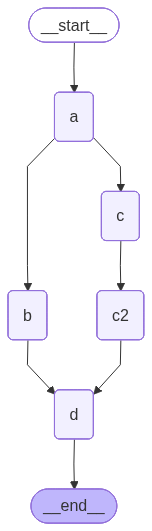

In [ ]:
builder = StateGraph(State)

builder.add_node("a", ReturnNode("I'm A"))
builder.add_node("b", ReturnNode("I'm B"))
builder.add_node("c", ReturnNode("I'm C"))
builder.add_node("c2", ReturnNode("I'm C2"))
builder.add_node("d", ReturnNode("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("c", "c2")
builder.add_edge(["b", "c2"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

Adding I'm A to state []
Adding I'm B to state ["I'm A"]
Adding I'm C to state ["I'm A"]
Adding I'm C2 to state ["I'm A", "I'm B", "I'm C"]
Adding I'm D to state ["I'm A", "I'm B", "I'm C", "I'm C2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm C2", "I'm D"]}

### LLM + WebSearch (Kinda like RAG)

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list[str], add]
    
def search_tavily(state: State):
    tavily_search = TavilySearchResults(max_results=2)
    search_docs = tavily_search.invoke(state["question"])
    
    formatted_content = "\n---\n".join([
        f"Title: {doc['title']} \n Content: {doc['content']}"
        for doc in search_docs
    ])
    
    return {"context": [formatted_content]}
    

def search_web(state: State):
    search_docs = WikipediaLoader(query=state["question"], load_max_docs=2).load()
    
    formatted_content = "\n---\n".join([
        f"Title: {doc.metadata['title']} \n Content: {doc.page_content}"
        for doc in search_docs
    ])
    
    return {"context": [formatted_content]}

def generate_answer(state: State):
    
    question = state["question"]
    context = state["context"]
    
    prompt = f"Answer the question: {question} based on the context: {context}"
    answer = llm.invoke([SystemMessage(content=prompt)] + [HumanMessage(content=question)])
    
    return {"answer": answer}


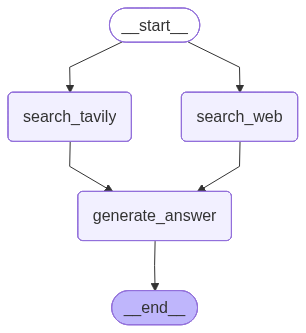

In [ ]:
builder = StateGraph(State)

builder.add_node("search_tavily",search_tavily)
builder.add_node("search_web", search_web)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_web")
builder.add_edge(START, "search_tavily")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_tavily", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "What is Bitcoin?"})
result['answer'].content

'Bitcoin is a cryptocurrency and a peer-to-peer digital currency that operates independently of a central authority. It enables direct transactions between users and utilizes cryptographic technology to secure these transactions, which are recorded on a transparent and immutable ledger known as the blockchain. Bitcoin allows for online transfers without needing intermediaries like banks, providing individuals with greater control over their own assets. It was created by a pseudonymous entity known as Satoshi Nakamoto, who introduced the concept in a 2008 white paper. Initially designed as a medium of exchange, Bitcoin is now often regarded as a store of value and has undergone significant growth since its inception in 2009.'

### Langgraph API

In [ ]:
client = get_client(url="http://127.0.0.1:2024")
thread = await client.threads.create()
input_question = {"question": "What is Ethereum?"}

In [ ]:
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="parallelization",
    input=input_question,
    stream_mode="values"
):
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

Ethereum is a decentralized, open-source platform that utilizes blockchain technology to enable the development and execution of smart contracts and decentralized applications (DApps). It was conceived in 2013 by programmer Vitalik Buterin and officially launched on July 30, 2015. Unlike Bitcoin, which primarily focuses on digital currency transactions, Ethereum allows developers to create a wide range of applications, including games, financial products, and digital art collections.

The native cryptocurrency of the Ethereum platform is called Ether (ETH), which is the second-largest cryptocurrency by market capitalization after Bitcoin. Ethereum supports various token standards, such as ERC-20 for fungible tokens and ERC-721 for non-fungible tokens (NFTs), facilitating the creation and management of these digital assets.

In September 2022, Ethereum transitioned from a proof-of-work (PoW) consensus mechanism to proof-of-stake (PoS) to improve energy efficiency and scalability. This t

## Sub-graphs

In [ ]:
def last_value(a: str, b: str) -> str:
    return b

class MainState(TypedDict):
    symbol: Annotated[str, last_value]
    processed_data: str
    recommendation: str
    
class DataCollectionState(TypedDict):
    symbol: str
    raw_data: Dict
    processed_data: Dict
    status: str
    
class AnalysisState(TypedDict):
    symbol: str
    technical_indicators: Dict
    sentiment_score: float
    recommendation: str
    

### Sub-Graph 1: Data Collection

In [ ]:
def fetch_market_data(state: DataCollectionState) -> DataCollectionState:
    
    # Example mock data (can use yfinance or other data api for real time)
    mock_data = {
        "price": random.uniform(100, 200),
        "volume": random.randint(1000000, 5000000),
        "high": random.uniform(200, 220),
        "low": random.uniform(90, 110),
        "change_percent": random.uniform(-5, 5)
    }
    
    state["raw_data"] = mock_data
    state["status"] = "Data Fetched"
    
    return state

def process_market_data(state: DataCollectionState) -> DataCollectionState:
    raw_data = state["raw_data"]
    
    # Example processed data (adjust with own asset)
    processed_data = {
        "current_price": raw_data["price"],
        "volume_normalized": raw_data["volume"] / 1000000,
        "price_range": raw_data["high"] - raw_data["low"],
        "volatility": abs(raw_data["change_percent"]),
        "trend": "bullish" if raw_data["change_percent"] > 0 else "bearish"
    }
    
    state["processed_data"] = processed_data
    state["status"] = "Complete"
    
    return {"processed_data": processed_data}

In [ ]:
fetch_market_data({"symbol": "BTC"})

{'symbol': 'BTC',
 'raw_data': {'price': 142.70236058547408,
  'volume': 3469521,
  'high': 208.27014407951,
  'low': 90.2517421861707,
  'change_percent': -3.4918786913596733},
 'status': 'Data Fetched'}

In [ ]:
process_market_data({'raw_data': {'price': 125.29096023706325,
  'volume': 1941984,
  'high': 207.5764368920291,
  'low': 106.7021791383776,
  'change_percent': -4.559702190073752}})

{'processed_data': {'current_price': 125.29096023706325,
  'volume_normalized': 1.941984,
  'price_range': 100.8742577536515,
  'volatility': 4.559702190073752,
  'trend': 'bearish'}}

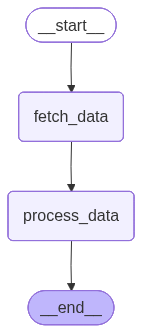

In [ ]:
sub_graph1 = StateGraph(DataCollectionState)
sub_graph1.add_node("fetch_data", fetch_market_data)
sub_graph1.add_node("process_data", process_market_data)
sub_graph1.add_edge(START, "fetch_data")
sub_graph1.add_edge("fetch_data", "process_data")
sub_graph1.add_edge("process_data", END)
sub_graph1.compile()

### Sub-graph 2:  Analysis Engine

In [ ]:
def analyze_market_indicator(state: AnalysisState) -> AnalysisState:
    
    # Example indicator data
    indicators = {
        "rsi": random.uniform(20, 80),
        "macd": random.uniform(-2, 2),  
        "bollinger_position": random.uniform(0, 1),
    }
    
    state["technical_indicators"] = indicators
    return state

def make_recommendation(state: AnalysisState) -> AnalysisState:
    
    sentiment_score = random.uniform(-1, 1) # Assume we did the sentiment based on indicator
    state["sentiment_score"] = sentiment_score
    
    if sentiment_score > 0.3:
        state["recommendation"] = "Buy"
    elif sentiment_score < -0.3:
        state["recommendation"] = "Sell"
    else:
        state["recommendation"] = "Hold"
    
    return {"recommendation": state["recommendation"]}

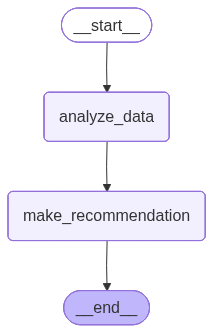

In [ ]:
sub_graph2 = StateGraph(AnalysisState)
sub_graph2.add_node("analyze_data", analyze_market_indicator)
sub_graph2.add_node("make_recommendation", make_recommendation)
sub_graph2.add_edge(START, "analyze_data")
sub_graph2.add_edge("analyze_data", "make_recommendation")
sub_graph2.add_edge("make_recommendation", END)
sub_graph2.compile()

### Main Graph

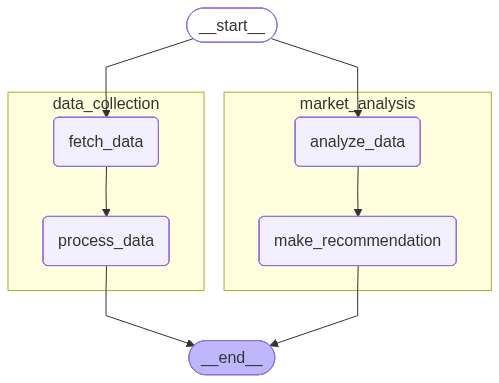

In [ ]:
main_graph = StateGraph(MainState)
main_graph.add_node("data_collection", sub_graph1.compile())
main_graph.add_node("market_analysis", sub_graph2.compile())

main_graph.add_edge(START, "data_collection")
main_graph.add_edge(START, "market_analysis")
main_graph.add_edge("data_collection", END) 
main_graph.add_edge("market_analysis", END) 
graph = main_graph.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "Subgraph"}}
graph.invoke({"symbol": "BTC"}, config=config)

{'symbol': 'BTC',
 'processed_data': {'current_price': 147.81505189238698,
  'volume_normalized': 2.308313,
  'price_range': 99.1082702734779,
  'volatility': 3.655219753614294,
  'trend': 'bearish'},
 'recommendation': 'Hold'}

## Map Reduce

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

In [ ]:
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

model = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list[str]
    jokes: Annotated[list, add]
    best_selected_joke: str
    
class Joke(BaseModel):
    joke: str
    
class JokeState(TypedDict):
    subject: str

    
def generate_topics(state: OverallState) -> OverallState:
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

def continue_jokes(state: OverallState) -> JokeState:
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

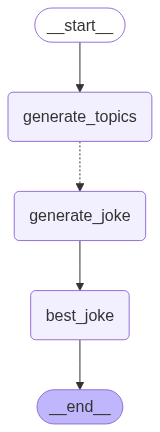

In [ ]:
def generate_joke(state: JokeState) -> OverallState:
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

builder = StateGraph(OverallState)
builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)
builder.add_edge(START, "generate_topics")
builder.add_conditional_edges("generate_topics", continue_jokes, ["generate_joke"])
builder.add_edge("generate_joke", "best_joke")
builder.add_edge("best_joke", END)

graph = builder.compile()
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
graph.invoke({"topic": "Programming"})

c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overr

{'topic': 'Programming',
 'subjects': ['Web Development',
  'Data Structures and Algorithms',
  'Software Testing'],
 'jokes': ['Why do web developers prefer dark mode? Because light attracts bugs!',
  "Why did the data structure break up with the algorithm? Because it found someone more 'array'-ing!",
  'Why do software testers prefer dark mode? Because light attracts bugs!'],
 'best_selected_joke': 'Why do web developers prefer dark mode? Because light attracts bugs!'}

In [ ]:
for joke in graph.stream({"topic": "Programming"}):
    print(joke)

c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'generate_topics': {'subjects': ['Web Development', 'Data Structures and Algorithms', 'Software Engineering']}}


c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overr

{'generate_joke': {'jokes': ['Why do programmers prefer dark mode? Because light attracts bugs!']}}
{'generate_joke': {'jokes': ['Why do web developers prefer dark mode? Because light attracts bugs!']}}
{'generate_joke': {'jokes': ["Why did the data structure break up with the algorithm? Because it found someone more 'array'-ing!"]}}


c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'best_joke': {'best_selected_joke': 'Why do web developers prefer dark mode? Because light attracts bugs!'}}


## Research Assistant

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

### Create Analyst

In [134]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class Analyst(BaseModel):
    affiliation: str = Field(description="Primary analyst affiliation")
    name: str = Field(description="Analyst name")
    role: str = Field(description="Analyst role based on topic context provided")
    description: str = Field(description="Description of analyst focus and expertise")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystStructuredOutput(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.",)

class GenerateAnalystState(TypedDict):
    topic: str
    max_analyst: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided if available to guide creation of the analysts: 

{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} unique themes.

5. Assign one analyst to each different theme."""
    

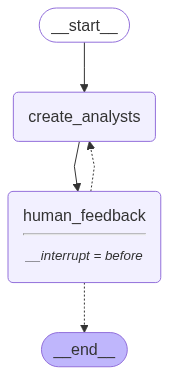

In [142]:
def create_analysts(state: GenerateAnalystState):
    topic = state["topic"]
    max_analyst = state["max_analyst"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")
    
    system_prompt = analyst_instructions.format(topic=topic, max_analysts=max_analyst, human_analyst_feedback=human_analyst_feedback)
    response = model.with_structured_output(AnalystStructuredOutput).invoke([SystemMessage(content=system_prompt)] + [HumanMessage(content='Generate the analyst in lists')])
    
    return {"analysts": response.analysts}


def human_feedback(state: GenerateAnalystState):
    pass


def should_continue(state: GenerateAnalystState):
    human_feedback = state.get("human_analyst_feedback", None)
    
    if human_feedback:
        return "create_analysts"
    
    return END   

builder = StateGraph(GenerateAnalystState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
Image(graph.get_graph().draw_mermaid_png())

#### Testing

In [143]:
max_analyst = 3
topic = "MCP Concept in LLM"
config = {"configurable": {"thread_id": "analyst"}}

for event in graph.stream({"topic": topic, "max_analyst": max_analyst}, config=config, stream_mode="values"):
    analyst = event.get("analysts", "")
    
    if analyst:
        print(f"=== Analyst ===")
        for a in analyst:
            print(a.persona)

=== Analyst ===
Name: Dr. Emily Chen
Role: Natural Language Processing Specialist
Affiliation: AI Research Institute
Description: Dr. Chen focuses on the integration of MCP concepts within large language models, exploring how these principles can enhance model interpretability and performance.

Name: Mr. Raj Patel
Role: AI Ethics Analyst
Affiliation: Tech Innovations Lab
Description: Mr. Patel examines the ethical implications of implementing MCP concepts in LLMs, particularly in relation to bias, fairness, and accountability in AI systems.

Name: Prof. Sarah Johnson
Role: Machine Learning Theorist
Affiliation: Data Science University
Description: Prof. Johnson investigates the theoretical foundations of MCP in LLMs, contributing to the understanding of model architecture and its impact on learning efficiency.



In [144]:
event

{'topic': 'MCP Concept in LLM',
 'max_analyst': 3,
 'analysts': [Analyst(affiliation='AI Research Institute', name='Dr. Emily Chen', role='Natural Language Processing Specialist', description='Dr. Chen focuses on the integration of MCP concepts within large language models, exploring how these principles can enhance model interpretability and performance.'),
  Analyst(affiliation='Tech Innovations Lab', name='Mr. Raj Patel', role='AI Ethics Analyst', description='Mr. Patel examines the ethical implications of implementing MCP concepts in LLMs, particularly in relation to bias, fairness, and accountability in AI systems.'),
  Analyst(affiliation='Data Science University', name='Prof. Sarah Johnson', role='Machine Learning Theorist', description='Prof. Johnson investigates the theoretical foundations of MCP in LLMs, contributing to the understanding of model architecture and its impact on learning efficiency.')]}

In [14]:
state = graph.get_state(config)
state.next

('human_feedback',)

In [15]:
graph.update_state(config, {"human_analyst_feedback": "Add leader from top AI company"}, as_node="human_feedback")

{'configurable': {'thread_id': 'analyst',
  'checkpoint_ns': '',
  'checkpoint_id': '1f088d7d-dde5-6f40-8002-053bda518ec7'}}

In [ ]:
for event in graph.stream(None, config=config, stream_mode="values"):
    analyst = event.get("analysts", "")
    
    if analyst:
        print(f"=== Analyst ===")
        for a in analyst:
            print(a.persona)

=== Analyst ===
Name: Dr. Emily Chen
Role: MCP Concept Specialist
Affiliation: AI Research Institute
Description: Dr. Chen focuses on the integration of the MCP concept within large language models, exploring its implications for AI ethics and user interaction.

Name: Mr. Raj Patel
Role: LLM Application Analyst
Affiliation: Tech Innovations Lab
Description: Mr. Patel specializes in the practical applications of LLMs, particularly how the MCP concept can enhance user experience and functionality in real-world scenarios.

Name: Prof. Sarah Johnson
Role: AI Theorist
Affiliation: University of Computational Sciences
Description: Prof. Johnson investigates the theoretical underpinnings of the MCP concept in LLMs, contributing to the academic discourse on AI development and its societal impacts.



c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


=== Analyst ===
Name: Dr. Emily Chen
Role: AI Research Director
Affiliation: OpenAI
Description: Dr. Chen specializes in the development and application of large language models (LLMs) with a focus on the MCP (Model Control Protocol) concept. She has extensive experience in AI ethics and governance, ensuring that LLMs are developed responsibly.

Name: Mr. Raj Patel
Role: Senior AI Strategist
Affiliation: Google DeepMind
Description: Mr. Patel leads initiatives on the integration of MCP in LLMs at Google DeepMind. His expertise lies in optimizing model performance and scalability, and he is a thought leader in the future of AI technologies.

Name: Dr. Sarah Thompson
Role: Principal AI Scientist
Affiliation: Microsoft Research
Description: Dr. Thompson focuses on the intersection of LLMs and human-computer interaction, particularly how MCP can enhance user experience. She is known for her innovative approaches to making AI more accessible and user-friendly.



In [146]:
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

# After we satisfied we can pass the human_feedback and next to END, so in this case we only pass the n max_analyst to next node
for event in graph.stream(None, config=config, stream_mode="values"):
    analyst = event.get("analysts", "")
    
    if analyst:
        print(f"=== Analyst ===")
        for a in analyst:
            print(a.persona)

=== Analyst ===
Name: Dr. Emily Chen
Role: Natural Language Processing Specialist
Affiliation: AI Research Institute
Description: Dr. Chen focuses on the integration of MCP concepts within large language models, exploring how these principles can enhance model interpretability and performance.

Name: Mr. Raj Patel
Role: AI Ethics Analyst
Affiliation: Tech Innovations Lab
Description: Mr. Patel examines the ethical implications of implementing MCP concepts in LLMs, particularly in relation to bias, fairness, and accountability in AI systems.

Name: Prof. Sarah Johnson
Role: Machine Learning Theorist
Affiliation: Data Science University
Description: Prof. Johnson investigates the theoretical foundations of MCP in LLMs, contributing to the understanding of model architecture and its impact on learning efficiency.



In [147]:
final_state = graph.get_state(config)
analysts = final_state.values.get('analysts')
print(final_state.next)
analysts

()


[Analyst(affiliation='AI Research Institute', name='Dr. Emily Chen', role='Natural Language Processing Specialist', description='Dr. Chen focuses on the integration of MCP concepts within large language models, exploring how these principles can enhance model interpretability and performance.'),
 Analyst(affiliation='Tech Innovations Lab', name='Mr. Raj Patel', role='AI Ethics Analyst', description='Mr. Patel examines the ethical implications of implementing MCP concepts in LLMs, particularly in relation to bias, fairness, and accountability in AI systems.'),
 Analyst(affiliation='Data Science University', name='Prof. Sarah Johnson', role='Machine Learning Theorist', description='Prof. Johnson investigates the theoretical foundations of MCP in LLMs, contributing to the understanding of model architecture and its impact on learning efficiency.')]

### Interview Section

#### Generate Question

In [136]:
class InterviewState(MessagesState):
    max_turns: int
    context: Annotated[list, add]
    analyst: Analyst
    interview: str
    sections: list
    
question_instruction = """
You are an analyst tasked to interview an expert to learn about specific topic

Imagine your profile are {persona}

Begin by introducing yourself that fits your persona, and then ask your question related to your expertise.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
"""

In [114]:
def generate_question(state: InterviewState):
    
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_prompt = question_instruction.format(persona=analyst.persona)
    question = model.invoke([SystemMessage(content=system_prompt)]+messages)
    
    return {"messages": [question]}

In [115]:
test_question = generate_question({"analyst": analysts[0], "messages": []})

In [22]:
test_question["messages"]

[AIMessage(content='Hello, I’m Dr. Emily Chen, the AI Research Director at OpenAI. My work primarily revolves around the development and application of large language models, particularly focusing on the Model Control Protocol (MCP) concept. I also have a strong emphasis on AI ethics and governance, ensuring that our advancements in AI are responsible and beneficial to society.\n\nI’d like to start our discussion by asking you about the Model Control Protocol. Can you explain how MCP enhances the control and interpretability of large language models, and perhaps share a specific example where it has been effectively implemented?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 218, 'total_tokens': 332, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 

#### Generate parallelization search and answer

In [116]:
search_instruction = """ 
You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a short well-structured web search query for tavily and wikipedia search.
"""

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

def search_web(state: InterviewState):
    tavily_search = TavilySearchResults(max_results=3)
    
    search_query = model.with_structured_output(SearchQuery).invoke([SystemMessage(content=search_instruction)] + state['messages'])
    search_tavily = tavily_search.invoke(search_query.search_query)
    
    formatted_docs = "\n---\n".join([
        f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
        for doc in search_tavily
    ])
    
    return {"context": [formatted_docs]}
    
def search_wikipedia(state: InterviewState):
    search_query = model.with_structured_output(SearchQuery).invoke([SystemMessage(content=search_instruction)] + state['messages'])
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()
    
    formatted_docs = "\n---\n".join([
        f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
        for doc in search_docs
    ])
    
    return {"context": [formatted_docs]}

In [24]:
tes_search = search_wikipedia({"messages": test_question["messages"]})

c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [25]:
tes_search

{'context': ['<Document source="https://en.wikipedia.org/wiki/Burroughs_Large_Systems" page=""/>\nThe Burroughs Large Systems Group produced a family of large 48-bit mainframes using stack machine instruction sets with dense syllables. The first machine in the family was the B5000 in 1961, which was optimized for compiling ALGOL 60 programs extremely well, using single-pass compilers. The B5000 evolved into the B5500 (disk rather than drum) and the B5700 (up to four systems running as a cluster). Subsequent major redesigns include the B6500/B6700 line and its successors, as well as the separate B8500 line.\nIn the 1970s, the Burroughs Corporation was organized into three divisions with very different product line architectures for high-end, mid-range, and entry-level business computer systems. Each division\'s product line grew from a different concept for how to optimize a computer\'s instruction set for particular programming languages. "Burroughs Large Systems" referred to all of th

In [117]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {persona}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    system_prompt = answer_instructions.format(persona=analyst.persona, context=context)
    answer = model.invoke([SystemMessage(content=system_prompt)]+messages)
    answer.name = "expert"
    
    return {"messages": [answer]}

In [27]:
tes_answer = generate_answer({"analyst": analysts[0], "messages": test_question["messages"], "context": tes_search["context"]})

In [28]:
tes_answer["messages"][0].model_dump()

{'content': "The Model Control Protocol (MCP) enhances the control and interpretability of large language models (LLMs) by providing a structured framework that allows developers to manage the behavior and outputs of these models more effectively. MCP facilitates the specification of constraints and guidelines that the model must adhere to during its operation, which is crucial for ensuring that the outputs align with ethical standards and user expectations.\n\nFor instance, in the context of LLMs, MCP can be used to define specific parameters that govern how the model responds to user queries. This might include setting limits on the types of content the model can generate, ensuring that it avoids producing harmful or biased outputs. By implementing MCP, developers can create a more transparent interaction between users and the model, allowing for better understanding and trust in the AI's capabilities.\n\nA specific example of MCP in action could be seen in applications where LLMs ar

In [29]:
print(tes_answer['messages'][0].content)

The Model Control Protocol (MCP) enhances the control and interpretability of large language models (LLMs) by providing a structured framework that allows developers to manage the behavior and outputs of these models more effectively. MCP facilitates the specification of constraints and guidelines that the model must adhere to during its operation, which is crucial for ensuring that the outputs align with ethical standards and user expectations.

For instance, in the context of LLMs, MCP can be used to define specific parameters that govern how the model responds to user queries. This might include setting limits on the types of content the model can generate, ensuring that it avoids producing harmful or biased outputs. By implementing MCP, developers can create a more transparent interaction between users and the model, allowing for better understanding and trust in the AI's capabilities.

A specific example of MCP in action could be seen in applications where LLMs are deployed in sen

#### Save interview and writing

In [118]:
def save_interview(state: InterviewState):
    messages = state["messages"]
    
    interview = get_buffer_string(messages)
    
    return {"interview": interview}
    
def route_messages(state: InterviewState, name: str = "expert"):
    
    messages = state["messages"]
    max_turn = state.get("max_turns", 2) 
    
    num_response = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    
    if max_turn <= num_response:
        return "save_interview"
    
    if "Thank you so much for your help" in messages[-2].content:
        return "save_interview"
    
    return "ask_question"

In [31]:
tes_interview = save_interview(tes_answer)
tes_interview

{'interview': "AI: The Model Control Protocol (MCP) enhances the control and interpretability of large language models (LLMs) by providing a structured framework that allows developers to manage the behavior and outputs of these models more effectively. MCP facilitates the specification of constraints and guidelines that the model must adhere to during its operation, which is crucial for ensuring that the outputs align with ethical standards and user expectations.\n\nFor instance, in the context of LLMs, MCP can be used to define specific parameters that govern how the model responds to user queries. This might include setting limits on the types of content the model can generate, ensuring that it avoids producing harmful or biased outputs. By implementing MCP, developers can create a more transparent interaction between users and the model, allowing for better understanding and trust in the AI's capabilities.\n\nA specific example of MCP in action could be seen in applications where L

In [119]:

section_writer_instructions = """
You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{description}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.


- It will look like:

### Example Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    analyst = state["analyst"]
    interview = state["interview"]
    context = state["context"]
    
    system_prompt = section_writer_instructions.format(description=analyst.description)
    section = model.invoke([SystemMessage(content=system_prompt)]+[HumanMessage(content=f"Use this interview as context: {interview}")])
    
    return {"sections": [section.content]}

In [33]:
tes_section = write_section({"analyst": analysts[0], "interview": tes_interview})

In [87]:
tes_section

{'sections': ['## Enhancing Control and Interpretability in Large Language Models through MCP\n\n### Summary\nThe Model Control Protocol (MCP) is a groundbreaking framework designed to enhance the control and interpretability of large language models (LLMs). As the demand for responsible AI development grows, MCP emerges as a vital tool for developers, enabling them to manage the behavior and outputs of LLMs more effectively. This structured approach allows for the specification of constraints and guidelines that the models must adhere to, ensuring that their outputs align with ethical standards and user expectations.\n\nOne of the most interesting insights from the interview is the practical application of MCP in sensitive fields such as healthcare and legal advice. In these contexts, the protocol can enforce strict guidelines on the information generated by LLMs, ensuring that responses are safe, accurate, and compliant with relevant regulations. This capability not only enhances the

#### Interview Graph

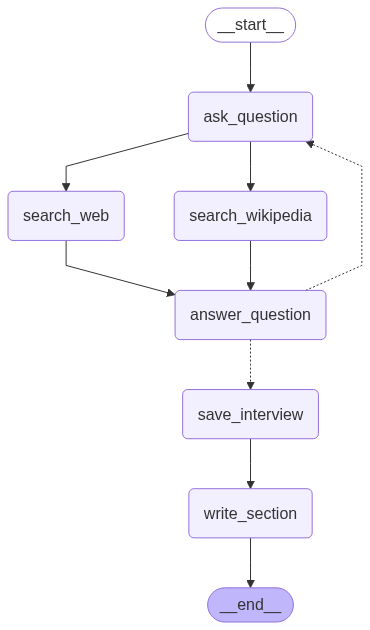

In [120]:
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [35]:
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
config = {"configurable": {"thread_id": "analyst"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, config=config)
Markdown(interview['sections'][0])

C:\Users\asus\AppData\Local\Temp\ipykernel_24068\2739573876.py:17: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)
c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported 

## Advancing AI Responsibly: Insights into the Model Control Protocol (MCP) in Large Language Models

### Summary
The Model Control Protocol (MCP) is a groundbreaking concept in the realm of large language models (LLMs), focusing on enhancing their management and control to align with human values and ethical standards. Dr. Emily Chen, an expert in AI ethics and governance, emphasizes the importance of MCP in ensuring that LLMs are not only effective but also responsible in their applications. 

One of the most intriguing aspects of MCP is its ability to provide real-time data access, allowing LLMs to query live databases and deliver up-to-date insights. This capability significantly enhances the model's responsiveness, making it more relevant in fast-paced environments [1]. Furthermore, MCP empowers LLMs to perform actionable tasks, such as updating schedules and triggering workflows, without the need for separate integrations. This versatility positions LLMs as more than just conversational agents; they become proactive tools capable of executing complex tasks [1].

Another novel feature of MCP is its context-aware response mechanism. By maintaining an ongoing thread of information, LLMs can engage in more coherent and informed interactions, which is crucial for user experience. This is achieved through a specialized architecture that includes a state management system designed to track relevant information across numerous concurrent conversations [1]. The integration of real-time context updates ensures that the information remains current, a significant improvement over traditional models that rely on static training data [1].

However, the implementation of MCP is not without challenges. Maintaining consistency and minimizing latency while managing context across multiple interactions can be complex. As the number of concurrent requests increases, ensuring coherent context becomes a critical area for ongoing research and development [3]. Despite these challenges, the potential of MCP to enhance LLM capabilities through structured insights and anomaly detection mechanisms is promising [2].

In summary, the MCP concept represents a significant advancement in the development of LLMs, fostering responsible AI applications that are both effective and aligned with ethical standards.

### Sources
[1] https://www.curotec.com/insights/the-model-context-protocol-mcp/  
[2] https://modelcontextprotocol.io/  
[3] https://www.groundcover.com/blog/mcp-server  

### Parallelize analyst interview

In [ ]:
class ResearchState(TypedDict):
    topic: str
    max_analyst: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, add]
    content: str
    introduction: str
    conclusion: str
    final_report: str

In [ ]:
def initiate_interviewer(state: ResearchState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = model.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchState):
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = model.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchState):
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = model.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

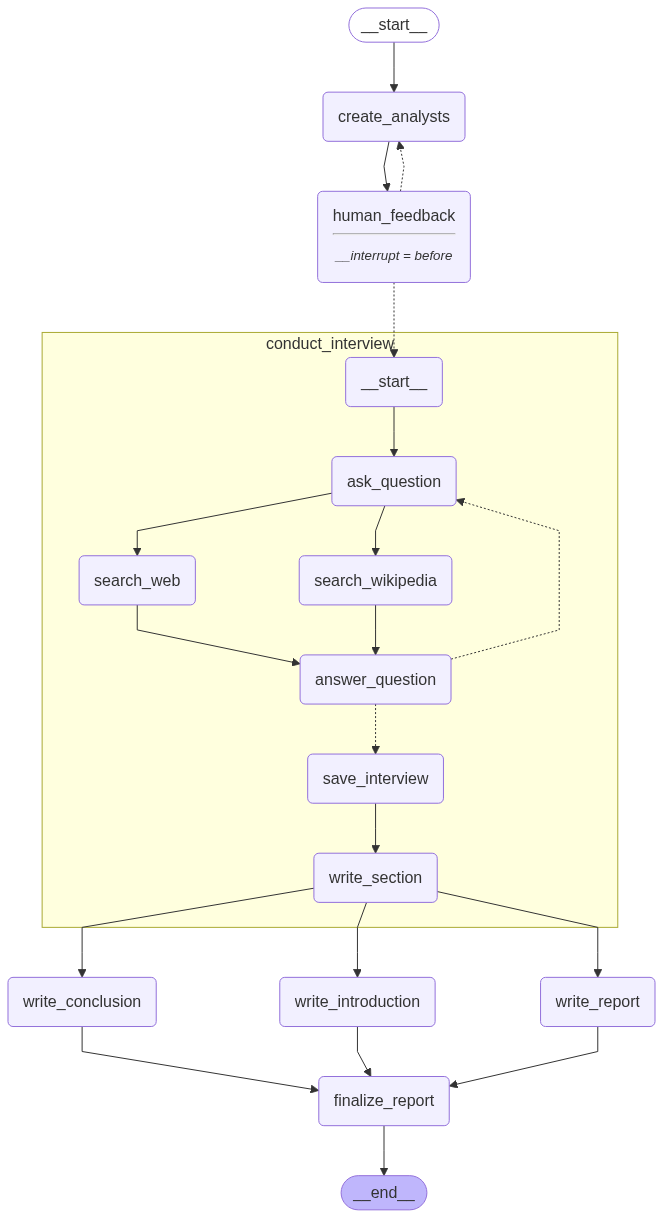

In [168]:
builder = StateGraph(ResearchState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_interviewer, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [169]:
# Inputs
max_analysts = 3 
topic = "Artificial Intelligence"
config = {"configurable": {"thread_id": "final_research"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic, "max_analyst":max_analysts}, config=config, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(analyst.persona)

Name: Dr. Emily Carter
Role: AI Ethics Researcher
Affiliation: Tech Innovations Lab
Description: Dr. Carter focuses on the ethical implications of AI technologies, exploring issues such as bias, accountability, and the societal impact of AI deployment.

Name: Mr. James Liu
Role: AI Applications Specialist
Affiliation: Future AI Institute
Description: Mr. Liu specializes in the practical applications of AI across various industries, including healthcare, finance, and transportation, analyzing case studies and emerging trends.

Name: Ms. Sarah Thompson
Role: AI Policy Analyst
Affiliation: Global AI Policy Center
Description: Ms. Thompson examines the regulatory landscape surrounding AI, advocating for policies that promote innovation while ensuring public safety and privacy.



In [77]:
graph.update_state(config, {"human_analyst_feedback": "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': 'final_research',
  'checkpoint_ns': '',
  'checkpoint_id': '1f088dcb-b775-6379-8002-268da4416ee0'}}

In [78]:
for event in graph.stream(None, config=config, stream_mode="values"):
    analysts = event.get('analyst', '')
    if analysts:
        for analyst in analysts:
            print(analyst.persona)

Name: Dr. Alice Thompson
Role: AI Ethics Specialist
Affiliation: Tech Innovations Inc.
Description: Dr. Alice Thompson focuses on the ethical implications of artificial intelligence, exploring issues such as bias, accountability, and the societal impact of AI technologies.

Name: Mr. John Carter
Role: AI Applications Analyst
Affiliation: Future Tech Research Group
Description: Mr. John Carter specializes in the practical applications of AI across various industries, analyzing trends, case studies, and the effectiveness of AI solutions in real-world scenarios.

Name: Dr. Emily Zhang
Role: AI Research Scientist
Affiliation: Data Science Institute
Description: Dr. Emily Zhang conducts advanced research in machine learning and deep learning, focusing on developing innovative algorithms and enhancing AI capabilities.



c:\Users\asus\anaconda3\envs\llms\Lib\site-packages\langchain_openai\chat_models\base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


Name: Alex Johnson
Role: CEO
Affiliation: Gen AI Native Startup
Description: Alex Johnson is the CEO of a leading Gen AI native startup, focusing on the integration of AI technologies in business operations and product development. With a background in computer science and entrepreneurship, Alex specializes in driving innovation and scaling AI solutions for various industries.

Name: Dr. Emily Chen
Role: AI Ethics Researcher
Affiliation: AI Research Institute
Description: Dr. Emily Chen is an AI Ethics Researcher at the AI Research Institute, where she explores the ethical implications of artificial intelligence. Her work focuses on bias in AI algorithms, transparency, and the societal impact of AI technologies, aiming to promote responsible AI development.

Name: Michael Smith
Role: AI Product Strategist
Affiliation: Tech Innovation Hub
Description: Michael Smith is an AI Product Strategist at a prominent Tech Innovation Hub. He specializes in identifying market trends and consumer ne

In [170]:
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

for event in graph.stream(None, config, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [172]:
final_state = graph.get_state(config)
report = final_state.values.get('final_report')
Markdown(report)

# The Future of Artificial Intelligence: Ethics, Applications, and Regulation

## Introduction

Artificial Intelligence (AI) is reshaping our world, presenting both remarkable opportunities and significant challenges. This report delves into the ethical implications of AI technologies, highlighting the urgent need to address bias and accountability in systems that impact critical areas like criminal justice, healthcare, and recruitment. We explore transformative applications in healthcare, showcasing how AI enhances treatment personalization and diagnostic accuracy. Additionally, we navigate the evolving regulatory landscape, emphasizing the balance between fostering innovation and ensuring public safety. Together, these sections underscore the importance of responsible AI development to create a fairer and more equitable society.

---


Artificial Intelligence (AI) is rapidly transforming various sectors, with significant implications for ethics, healthcare, and regulatory frameworks. The integration of AI technologies raises critical ethical concerns, particularly regarding bias and accountability. Experts emphasize the urgent need to address these issues to prevent adverse societal impacts.

The ethical implications of AI technologies are profound, particularly concerning bias in AI systems. Bias can manifest in critical areas such as criminal justice, healthcare, and recruitment, leading to unjust outcomes for marginalized communities. For instance, algorithms in the criminal justice system may disproportionately target these groups, resulting in unfair sentencing and increased surveillance. In healthcare, biased algorithms can lead to misdiagnosis or inappropriate treatments, as seen with pharmacogenetic algorithms that perform poorly for certain demographics due to the exclusion of relevant genetic variations. To combat these challenges, experts advocate for robust regulatory frameworks and international standards for AI bias detection, such as the ISO/IEC TR 24027:2021 and the NIST AI Risk Management Framework, which emphasize accountability and transparency in AI processes.

In healthcare, AI is revolutionizing treatment personalization and diagnostic accuracy. Advanced algorithms are enabling more effective treatment recommendations, particularly in psychiatric care, where traditional methods have often relied on trial and error. The PETRUSHKA algorithm exemplifies this shift by personalizing antidepressant selection based on a multitude of factors, including genetic profiles and symptom severity. Beyond psychiatric care, AI applications are emerging globally, such as in Ethiopia, where AI models analyze photographs to identify signs of polio-related paralysis, and in Peru, where AI-driven breathalyzers assist in diagnosing respiratory diseases. These innovations highlight AI's potential to enhance patient care and improve health outcomes.

As AI technologies evolve, the regulatory landscape is becoming increasingly complex. Recent legislative measures, such as the Algorithmic Accountability Act of 2023 and the EU AI Act, aim to enhance transparency and accountability in AI systems. These initiatives require companies to evaluate the impacts of their AI systems and disclose critical information about their models, fostering fair competition and public trust. The OECD also emphasizes the importance of a risk-management framework throughout the AI system lifecycle to promote trustworthy AI. Organizations that prioritize accountability are finding that it enhances trust among users and stakeholders, positioning them to innovate responsibly while mitigating risks early in the development process.

In summary, the integration of AI into various sectors presents both opportunities and challenges. Addressing ethical implications, enhancing healthcare applications, and navigating the regulatory landscape are crucial for ensuring that AI technologies are deployed responsibly and equitably.


---

## Conclusion

The exploration of artificial intelligence (AI) reveals its profound impact across various sectors, particularly in healthcare and regulatory frameworks. We examined the ethical implications of AI technologies, highlighting the urgent need to address bias and accountability to prevent societal harm. The transformative applications of AI in healthcare demonstrate its potential to enhance treatment personalization and diagnostic accuracy, paving the way for improved patient outcomes. Furthermore, navigating the regulatory landscape is crucial for balancing innovation with public safety, as seen in recent legislative measures promoting algorithmic accountability. Collectively, these insights underscore the necessity for robust frameworks that ensure ethical AI development and deployment, fostering a future where technology serves all of society equitably.

## Sources
[1] https://www.ibm.com/think/topics/algorithmic-bias  
[2] https://www.paubox.com/blog/real-world-examples-of-healthcare-ai-bias  
[3] https://www.sap.com/resources/what-is-ai-bias  
[4] https://publicpolicy.ie/papers/bias-in-ai-tackling-the-issues-through-regulations-and-standards/  
[5] https://blog.rsisecurity.com/addressing-ai-bias-how-nist-ai-rmf-can-help/  
[6] https://wjarr.com/sites/default/files/WJARR-2024-2510.pdf  
[7] https://medicalfuturist.com/the-curious-case-of-a.i-discovering-unusual-associations-in-medicine/  
[8] https://www.coursera.org/articles/ai-in-health-care  
[9] https://psych.ox.ac.uk/news/ai-to-help-personalise-treatment-for-depression-in-oxfordshire-as-part-of-major-trial  
[10] https://research.aimultiple.com/ai-for-mental-health/  
[11] https://pmc.ncbi.nlm.nih.gov/articles/PMC8349367/  
[12] https://www.wyden.senate.gov/imo/media/doc/algorithmic_accountability_act_of_2023_summary.pdf  
[13] https://www.frontiersin.org/journals/human-dynamics/articles/10.3389/fhumd.2024.1421273/full  
[14] https://www.oecd.org/content/dam/oecd/en/publications/reports/2023/02/advancing-accountability-in-ai_753bf8c8/2448f04b-en.pdf  
[15] https://www.dasca.org/world-of-data-science/article/responsible-ai-ethics-challenges-and-benefits  
[16] https://infusedinnovations.com/blog/responsible-ai-accountability  
[17] https://www.informationpolicycentre.com/uploads/5/7/1/0/57104281/cipl_building_accountable_ai_programs_23_feb_2024.pdf

# Long Term Memory

## Chatbot with Memory

**InMemoryStore** works like MemorySaver which saves in RAM, but it able to run across thread and allow multithread processing

But `MemorySaver` run single-thread by default while `InMemoryStore` allow async and multi-thread

In [3]:
in_memory_store = InMemoryStore()

In [7]:
namespaces = ("tes_id1", "memory")
keys = str(uuid.uuid4())
values = {"Crypto preference": "ETH"}

in_memory_store.put(namespaces, keys, values)

In [8]:
memory = in_memory_store.search(namespaces)
memory

[Item(namespace=['tes_id1', 'memory'], key='c3dd19c8-8064-4ff2-9397-22d1108ef4e7', value={'Crypto preference': 'ETH'}, created_at='2025-09-04T09:29:44.030812+00:00', updated_at='2025-09-04T09:29:44.030812+00:00', score=None)]

In [9]:
in_memory_store.get(namespaces, keys).dict()

{'namespace': ['tes_id1', 'memory'],
 'key': 'c3dd19c8-8064-4ff2-9397-22d1108ef4e7',
 'value': {'Crypto preference': 'ETH'},
 'created_at': '2025-09-04T09:29:44.030812+00:00',
 'updated_at': '2025-09-04T09:29:44.030812+00:00'}

### Building with chatbot

In [27]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [78]:
def exist_memory(config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memories')
    else:
        existing_memory_content = "No existing memory found."
        
    return existing_memory_content


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    existing_memory_content = exist_memory(config, store)

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}
    
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)

    existing_memory_content = exist_memory(config, store)
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    key = "user_memory"
    store.put(namespace, key, {"memories": new_memory.content})

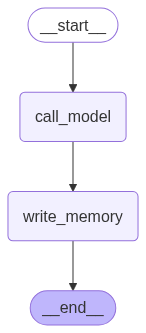

In [ ]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Across thread for long term memory
across_thread_memory = InMemoryStore()

# Within thread for short term memory
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [80]:
config = {"configurable": {"thread_id": "memory", "user_id": "tes_id1"}}

input_messages = [HumanMessage(content="Hello, I'm Derrick from Indonesia")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Derrick from Indonesia
================================== Ai Message ==================================

Hi Derrick! It's great to meet you. How's everything going in Indonesia?


In [81]:
input_messages = [HumanMessage(content="I like to know about crypto and AI")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to know about crypto and AI
================================== Ai Message ==================================

That's interesting! Both crypto and AI are rapidly evolving fields. Are you looking for specific information or updates on either topic?


In [82]:
config = {"configurable": {"thread_id": "memory"}}
state = graph.get_state(config).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hello, I'm Derrick from Indonesia
================================== Ai Message ==================================

Hi Derrick! It's great to meet you. How's everything going in Indonesia?
================================ Human Message =================================

I like to know about crypto and AI
================================== Ai Message ==================================

That's interesting! Both crypto and AI are rapidly evolving fields. Are you looking for specific information or updates on either topic?


Lets recall our compiled graph in store

In [85]:
namespace = ("memories", "tes_id1")
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memories', 'tes_id1'],
 'key': 'user_memory',
 'value': {'memories': '- Name: Derrick\n- Location: Indonesia\n- Interests: Crypto, AI'},
 'created_at': '2025-09-04T08:39:57.346716+00:00',
 'updated_at': '2025-09-04T08:39:57.346716+00:00'}

Let's try use another thread and see if the model could remmember my profile

In [86]:
config = {"configurable": {"thread_id": "2", "user_id": "tes_id1"}}

# User input 
input_messages = [HumanMessage(content="What asset would you recommend I invest in?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What asset would you recommend I invest in?
================================== Ai Message ==================================

Given your interests in crypto and AI, you might consider looking into cryptocurrencies that are focused on AI applications, such as SingularityNET (AGI) or Fetch.ai (FET). These projects aim to integrate AI with blockchain technology, which could align well with your interests. 

Additionally, you might want to explore established cryptocurrencies like Bitcoin or Ethereum, as they tend to be more stable compared to newer projects. Always remember to do thorough research and consider your risk tolerance before investing!


In [87]:
namespace = ("memories", "tes_id1")
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memories', 'tes_id1'],
 'key': 'user_memory',
 'value': {'memories': 'Here is the updated user information based on the chat history:\n\n- Name: Derrick\n- Location: Indonesia\n- Interests: \n  - Crypto\n  - AI\n- Preferences: Interested in investing in assets related to crypto and AI.'},
 'created_at': '2025-09-04T08:48:12.414794+00:00',
 'updated_at': '2025-09-04T08:48:12.414794+00:00'}

## Memory Schema Profile

### Define schema and profile

In [76]:
class UserProfile(TypedDict):
    name: str
    interests: List[str]
    
user_profile: UserProfile = {
    "name": "Derrick",
    "interests": ["coffee", "crypto", "AI"]
}

In [77]:
in_memory_store = InMemoryStore()

namespace = ("id1", "memories")
key = "profile"
value = user_profile

in_memory_store.put(namespace, key, value)

In [78]:
for memory in in_memory_store.search(namespace):
    print(memory.dict())
    
print("======" * 20)
print(in_memory_store.get(namespace, key).value)

{'namespace': ['id1', 'memories'], 'key': 'profile', 'value': {'name': 'Derrick', 'interests': ['coffee', 'crypto', 'AI']}, 'created_at': '2025-09-04T13:31:14.301729+00:00', 'updated_at': '2025-09-04T13:31:14.301729+00:00', 'score': None}
{'name': 'Derrick', 'interests': ['coffee', 'crypto', 'AI']}


### Chatbot Profile (with structured output)

In [79]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

model_structured = model.with_structured_output(UserProfile)
structured_response = model_structured.invoke("Hello, I'm derrick from indonesia and i like crypto and AI")

In [80]:
structured_response

{'name': 'Derrick', 'interests': ['crypto', 'AI']}

In [81]:
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [82]:
def exist_memory(config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    if existing_memory and existing_memory.value:
        existing_memory_content = (f"Name: {existing_memory.value.get('name', 'N/A')}\nInterests: {', '.join(existing_memory.value.get('interests', []))}")
    else:
        existing_memory_content = None
        
    return existing_memory_content


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    existing_memory_content = exist_memory(config, store)

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}
    
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)

    existing_memory_content = exist_memory(config, store)
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model_structured.invoke([SystemMessage(content=system_msg)]+state['messages'])

    key = "user_memory"
    store.put(namespace, key, new_memory)

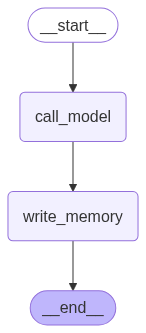

In [83]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Across thread for long term memory
across_thread_memory = InMemoryStore()

# Within thread for short term memory
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [84]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hello, I'm derrick, right now i like to learn AI and LLM especially AI Automation")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm derrick, right now i like to learn AI and LLM especially AI Automation
================================== Ai Message ==================================

Hi Derrick! It's great to meet you. AI and LLMs (Large Language Models) are fascinating areas to explore, especially with the growing interest in AI automation. What specific aspects of AI automation are you interested in learning about?


In [85]:
namespace = ("memories", "1")
existing_memory = across_thread_memory.get(namespace, "user_memory") # namespace, key
existing_memory.value

{'name': 'Derrick', 'interests': ['AI', 'LLM', 'AI Automation']}

### Trustcall to create and update schema

`with_structured_output` is very useful but sometimes it raised error when we work with more complex schema, also extracting entire schemas from scratch can be inefficient for token usage

This is where `trustcall`, part of langchain library comes in

In [88]:
class UserProfile(TypedDict):
    name: str = Field(description="The user preferred name")
    interests: List[str] = Field(description="List of user interests")
    
trustcall_extractor = create_extractor(model, tools=[UserProfile], tool_choice="UserProfile")

conversation = [
    HumanMessage(content="Hello, I'm derrick, right now i like to learn AI and LLM especially AI Automation"),
    AIMessage(content="Hello Derrick! It's great to meet you. AI and LLMs are fascinating fields with so much potential. What specifically about AI Automation interests you?"),
    HumanMessage(content="I like to know how to use AI to automate my work, and I also like crypto"),
]
system_msg = "Extract the user profile from the following conversation"
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

In [89]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_tPOEFaUpLN6NLzUxpUyfuj4Q)
 Call ID: call_tPOEFaUpLN6NLzUxpUyfuj4Q
  Args:
    name: derrick
    interests: ['AI Automation', 'crypto']


In [99]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tPOEFaUpLN6NLzUxpUyfuj4Q', 'function': {'arguments': '{"name":"derrick","interests":["AI Automation","crypto"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 333, 'total_tokens': 348, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CC4RDXSDeQDk2AgKveNltYus6otvL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9ed1261b-a57f-4ebe-9f20-b6558a37b898-0', tool_calls=[{'name': 'UserProfile', 'args': {'name': 'derrick', 'interests': ['AI Automation', 'crypto']}, 'id': 'call_tPOEFaUpLN6NLzUxpUyfuj4Q', 'type': 'tool_call'}], usage_metadat

In [98]:
schema = result["responses"][0].model_dump()
schema

{'name': 'derrick', 'interests': ['AI Automation', 'crypto']}

In [100]:
updated_conversation = [
    HumanMessage(content="Hello, I'm derrick, right now i like to learn AI and LLM especially AI Automation"),
    AIMessage(content="Hello Derrick! It's great to meet you. AI and LLMs are fascinating fields with so much potential. What specifically about AI Automation interests you?"),
    HumanMessage(content="I like to know how to use AI to automate my work, and I also like crypto"),
    AIMessage(content="That's awesome, Derrick! AI can definitely help streamline many tasks and improve efficiency. Since you're interested in crypto as well, have you thought about how AI could be applied in that space? For example, AI can assist with market analysis, trading strategies, and even fraud detection in the crypto world. What are your thoughts on that?"),
    HumanMessage(content="Yes, I think AI can help me to analyze but not only crypto but also stocks market, anyway I also like coffee."),
]


system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema}})  

In [101]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_btquyB7APoTwtfrPxgr0MXlU)
 Call ID: call_btquyB7APoTwtfrPxgr0MXlU
  Args:
    name: Derrick
    interests: ['AI', 'LLM', 'AI Automation', 'crypto', 'stock market', 'coffee']


In [103]:
result["responses"][0].model_dump()

{'name': 'Derrick',
 'interests': ['AI',
  'LLM',
  'AI Automation',
  'crypto',
  'stock market',
  'coffee']}

### Trustcall chatbot

In [104]:
class UserProfile(BaseModel):
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",
)

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)


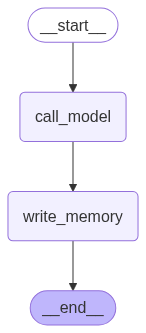

In [106]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Across thread for long term memory
across_thread_memory = InMemoryStore()

# Within thread for short term memory
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [107]:
config = {"configurable": {"thread_id": "memory", "user_id": "tes_id1"}}

input_messages = [HumanMessage(content="Hello, I'm Derrick from Indonesia")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Derrick from Indonesia
================================== Ai Message ==================================

Hi Derrick! It's great to meet you. How's everything going in Indonesia?


In [108]:
input_messages = [HumanMessage(content="I like to know about crypto and AI")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to know about crypto and AI
================================== Ai Message ==================================

That's awesome, Derrick! Both crypto and AI are fascinating fields with a lot of developments happening. Are you interested in any specific aspects of crypto, like trading, technology, or blockchain? And for AI, are you more into its applications, ethical considerations, or something else?


In [117]:
namespace = ("memory", "tes_id1")
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', 'tes_id1'],
 'key': 'user_memory',
 'value': {'user_name': 'Derrick',
  'user_location': 'Indonesia',
  'interests': ['crypto', 'AI']},
 'created_at': '2025-09-04T14:01:58.587756+00:00',
 'updated_at': '2025-09-04T14:01:58.587756+00:00'}

In [118]:
input_messages = [HumanMessage(content="I also want to know about stocks market")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also want to know about stocks market
================================== Ai Message ==================================

Got it! The stock market is another interesting area to explore. It involves buying and selling shares of companies, and it can be influenced by various factors like economic indicators, company performance, and market sentiment. Are you looking for information on how to get started, specific strategies, or something else related to the stock market?


In [119]:
namespace = ("memory", "tes_id1")
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', 'tes_id1'],
 'key': 'user_memory',
 'value': {'user_name': 'Derrick',
  'user_location': 'Indonesia',
  'interests': ['crypto', 'AI', 'stocks']},
 'created_at': '2025-09-04T14:03:45.226325+00:00',
 'updated_at': '2025-09-04T14:03:45.226325+00:00'}

## Memory Schema Collection

Instead of saving profile in fixed structured json format, we can create a flexible collection to store memories about user  

### Collection

In [2]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
in_memory_store = InMemoryStore()

class Memory(BaseModel):
    content: str = Field(description="The main memory of user content. For example: user expressed interest in coffee")
    
class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user")

In [3]:
model_structured = model.with_structured_output(MemoryCollection)

response = model_structured.invoke("Hello, I'm derrick from indonesia and i like crypto and AI")
response

MemoryCollection(memories=[Memory(content='Derrick is from Indonesia.'), Memory(content='Derrick likes crypto.'), Memory(content='Derrick likes AI.')])

In [4]:
response.model_dump()

{'memories': [{'content': 'Derrick is from Indonesia.'},
  {'content': 'Derrick likes crypto.'},
  {'content': 'Derrick likes AI.'}]}

In [5]:
namespace = ("1", "memories")
key = str(uuid.uuid4())
value = response.memories[0].model_dump()
in_memory_store.put(namespace, key, value)

key = str(uuid.uuid4())
value = response.memories[1].model_dump()
in_memory_store.put(namespace, key, value)

In [6]:
for m in in_memory_store.search(namespace):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '99c2430b-31b4-499b-836a-82350ce6ddb3', 'value': {'content': 'Derrick is from Indonesia.'}, 'created_at': '2025-09-05T05:47:10.029844+00:00', 'updated_at': '2025-09-05T05:47:10.029844+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': 'c471a4cb-5d1b-488b-aa31-c600e5475a7d', 'value': {'content': 'Derrick likes crypto.'}, 'created_at': '2025-09-05T05:47:10.029844+00:00', 'updated_at': '2025-09-05T05:47:10.030433+00:00', 'score': None}


In [30]:
tes = in_memory_store.search(namespace)
tes

[Item(namespace=['1', 'memories'], key='99c2430b-31b4-499b-836a-82350ce6ddb3', value={'content': 'Derrick is from Indonesia.'}, created_at='2025-09-05T05:47:10.029844+00:00', updated_at='2025-09-05T05:47:10.029844+00:00', score=None),
 Item(namespace=['1', 'memories'], key='c471a4cb-5d1b-488b-aa31-c600e5475a7d', value={'content': 'Derrick likes crypto.'}, created_at='2025-09-05T05:47:10.029844+00:00', updated_at='2025-09-05T05:47:10.030433+00:00', score=None)]

In [ ]:
for i in tes:
    print(i)

99c2430b-31b4-499b-836a-82350ce6ddb3
c471a4cb-5d1b-488b-aa31-c600e5475a7d


### Update Schemas

In [7]:
# enable inserts
trustcall_extractor = create_extractor(model, tools=[Memory], tool_choice="Memory", enable_inserts=True)

instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [
    HumanMessage(content="Hello, I'm derrick, right now i like to learn AI and LLM especially AI Automation"),
    AIMessage(content="Hello Derrick! It's great to meet you. AI and LLMs are fascinating fields with so much potential. What specifically about AI Automation interests you?"),
    HumanMessage(content="I like to know how to use AI to automate my work, and I also like crypto"),
]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [ ]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_C8K2pJ50gzg4DRvKkbqhJw1z)
 Call ID: call_C8K2pJ50gzg4DRvKkbqhJw1z
  Args:
    content: User is interested in learning how to use AI to automate work and has an interest in cryptocurrency.


In [12]:
result["responses"][0].model_dump()

{'content': 'User is interested in learning how to use AI to automate work and has an interest in cryptocurrency.'}

In [ ]:
updated_conversation = [
    AIMessage(content="That's awesome, Derrick! AI can definitely help streamline many tasks and improve efficiency. Since you're interested in crypto as well, have you thought about how AI could be applied in that space? For example, AI can assist with market analysis, trading strategies, and even fraud detection in the crypto world. What are your thoughts on that?"),
    HumanMessage(content="Yes, I think AI can help me to analyze but not only crypto but also stocks market"),
    AIMessage(content="Alright, I assume you're talking stock market especially in Indonesia isn't it?"),
    HumanMessage(content="Yes, but i also want to know about US market")
]

tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] # id, key, value
existing_memories

[('0',
  'Memory',
  {'content': 'User is interested in learning how to use AI to automate work and has an interest in cryptocurrency.'})]

In [15]:
result = trustcall_extractor.invoke({"messages": updated_conversation, "existing": existing_memories})

In [17]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_qFjV8zzWmRPpoCLbXV195nqo)
 Call ID: call_qFjV8zzWmRPpoCLbXV195nqo
  Args:
    content: User is interested in learning how to use AI to automate work and has an interest in cryptocurrency and stock market analysis.
  Memory (call_eaRkWCNdhYHl8QHCTubVeD15)
 Call ID: call_eaRkWCNdhYHl8QHCTubVeD15
  Args:
    content: User is interested in learning how to use AI to analyze both cryptocurrency and stock markets, including markets in Indonesia and the US.


In [48]:
result["response_metadata"]

[{'id': 'call_qFjV8zzWmRPpoCLbXV195nqo', 'json_doc_id': '0'},
 {'id': 'call_eaRkWCNdhYHl8QHCTubVeD15'}]

In [54]:
for r_meta in result["response_metadata"]:
    print(r_meta.get("json_doc_id", str(uuid.uuid4())))

0
301c3c1d-60a3-404c-9feb-d84f0c6a04ec


In [42]:
result["responses"][0].model_dump(mode="json")

{'content': 'User is interested in learning how to use AI to automate work and has an interest in cryptocurrency and stock market analysis.'}

### Chatbot Collection

In [11]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
namespace_id = "memories"

class Memory(BaseModel):
    content: str = Field(description="The main memory of user content. For example: user expressed interest in coffee")
    
trustcall_extractor = create_extractor(model, tools=[Memory], tool_choice="Memory", enable_inserts=True)

MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): {memory}
"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:
"""

In [40]:
def existing_memories(config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = (namespace_id, user_id)
    
    existing_memory = store.search(namespace)
    
    return existing_memory

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    existing_memory = existing_memories(config, store)
    
    memory = "\n".join([f"- {m.value.get('content')}" for m in existing_memory]) if existing_memory else "No existing memory found."
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=memory)
    
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])
    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    user_id = config["configurable"]["user_id"]
    namespace = (namespace_id, user_id)
    memories = store.search(namespace)

    tool_name = "Memory"
    existing_memory = ([(memory.key, tool_name, memory.value) for memory in memories] if memories else None)
    
    updated_message = list(merge_message_runs(messages= [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))
    
    response = trustcall_extractor.invoke({"messages": updated_message, "existing": existing_memory})
    
    for res, metadata in zip(response["responses"], response["response_metadata"]):
        store.put(namespace, metadata.get("json_doc_id", str(uuid.uuid4())), res.model_dump(mode="json"))
        
    return response

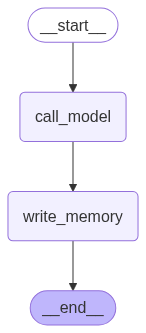

In [13]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "memory", "user_id": "tes_id1"}}

input_messages = [HumanMessage(content="Hello, I'm Derrick from Indonesia")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, I'm Derrick from Indonesia
================================== Ai Message ==================================

Hi Derrick! It's great to meet you. How's everything going in Indonesia?


In [15]:
memories = across_thread_memory.search((namespace_id, "tes_id1"))
for m in memories:
    print(m.dict())

{'namespace': ['memories', 'tes_id1'], 'key': '9539bf70-b72c-49c9-91ae-4114f01d5c01', 'value': {'content': "User's name is Derrick and he is from Indonesia."}, 'created_at': '2025-09-06T08:47:07.786857+00:00', 'updated_at': '2025-09-06T08:47:07.786857+00:00', 'score': None}


In [16]:
input_messages = [HumanMessage(content="I like to know about crypto and AI")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to know about crypto and AI
================================== Ai Message ==================================

That's interesting! Crypto and AI are both rapidly evolving fields. Are you more interested in the technology behind them, their applications, or perhaps the investment aspects?


In [17]:
memories = across_thread_memory.search((namespace_id, "tes_id1"))
for m in memories:
    print(m.dict())

{'namespace': ['memories', 'tes_id1'], 'key': '9539bf70-b72c-49c9-91ae-4114f01d5c01', 'value': {'content': "User's name is Derrick, he is from Indonesia, and he likes to know about crypto and AI."}, 'created_at': '2025-09-06T08:47:11.115374+00:00', 'updated_at': '2025-09-06T08:47:11.115374+00:00', 'score': None}
{'namespace': ['memories', 'tes_id1'], 'key': 'f39eff5a-f0ba-4ecb-8fd4-bf9575d7551d', 'value': {'content': 'User likes to know about crypto and AI.'}, 'created_at': '2025-09-06T08:47:11.115374+00:00', 'updated_at': '2025-09-06T08:47:11.115374+00:00', 'score': None}


In [18]:
input_messages = [HumanMessage(content="I actually learning about NLP especially LLM and AI Automation")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I actually learning about NLP especially LLM and AI Automation
================================== Ai Message ==================================

That's fantastic! Natural Language Processing (NLP) and Large Language Models (LLMs) are fascinating areas with so much potential. AI automation is also a game-changer in many industries. What specific aspects of NLP or AI automation are you focusing on?


In [19]:
memories = across_thread_memory.search((namespace_id, "tes_id1"))
for m in memories:
    print(m.dict())

{'namespace': ['memories', 'tes_id1'], 'key': '9539bf70-b72c-49c9-91ae-4114f01d5c01', 'value': {'content': "User's name is Derrick, he is from Indonesia, and he likes to know about crypto, AI, NLP, LLM, and AI Automation."}, 'created_at': '2025-09-06T08:47:16.084009+00:00', 'updated_at': '2025-09-06T08:47:16.084009+00:00', 'score': None}
{'namespace': ['memories', 'tes_id1'], 'key': 'f39eff5a-f0ba-4ecb-8fd4-bf9575d7551d', 'value': {'content': 'User likes to know about crypto and AI.'}, 'created_at': '2025-09-06T08:47:11.115374+00:00', 'updated_at': '2025-09-06T08:47:11.115374+00:00', 'score': None}
{'namespace': ['memories', 'tes_id1'], 'key': '85e70c5b-8891-45f8-91f0-2880c41d57cd', 'value': {'content': 'User is learning about NLP, especially LLM and AI Automation.'}, 'created_at': '2025-09-06T08:47:16.084009+00:00', 'updated_at': '2025-09-06T08:47:16.084009+00:00', 'score': None}


## Long Term Memory Agent

### Visibility in Trustcall

In [3]:
class Memory(BaseModel):
    content: str = Field(description="The main memory of user content. For example: user expressed interest in coffee")
    
class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user")

In [4]:
class Spy:
    def __init__(self):
        self.called_tools = []
        
    def __call__(self, run):
        q = [run]
        
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"])
        
        
spy = Spy()
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
trustcall_extractor = create_extractor(model, tools=[Memory], tool_choice="Memory", enable_inserts=True)

trustcall_tool = trustcall_extractor.with_listeners(on_end=spy)

In [5]:
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hello, I'm Derrick"), 
                AIMessage(content="Nice to meet you, Derrick."), 
                HumanMessage(content="This morning I had a meeting in Binus")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [6]:
print(result["responses"][0].model_dump()) 
print(result["messages"][0].model_dump()) 
print(result["response_metadata"][0]) 

{'content': 'User had a meeting in Binus this morning.'}
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_vRj6RVwvA6FBKWXPFnDU5utg', 'function': {'arguments': '{"content":"User had a meeting in Binus this morning."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 102, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CDXh4J2KIJjUa2Jub5jvW4HTQQzo9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--5952cef6-b919-43da-b9ad-cb36be19d43c-0', 'example': False, 'tool_calls': [{'name': 'Memory', 'args': {'content': 'User had a meeting in Binus this morning.'

In [7]:
for i, memory in enumerate(result["responses"]):
    print(i, memory.model_dump())

0 {'content': 'User had a meeting in Binus this morning.'}


In [8]:
updated_conversation = [AIMessage(content="That's great, any activities after that?"), 
                        HumanMessage(content="I went to Canteen and having lunch with my friends"),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about learning LLM after that!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0', 'Memory', {'content': 'User had a meeting in Binus this morning.'})]

In [9]:
result = trustcall_tool.invoke({"messages": updated_conversation, "existing": existing_memories})

In [10]:
for m in result["response_metadata"]: 
    print(m)
    
print("======" * 20)

for m in result["messages"]:
    m.pretty_print()
    
print("======" * 20)

for m in result["responses"]:
    print(m)
    


{'id': 'call_0lZieEyE29Mx2iHoGTJPLLEM', 'json_doc_id': '0'}
{'id': 'call_mq9pUP6CsHyZYtpsug3o6az2'}
================================== Ai Message ==================================
Tool Calls:
  Memory (call_0lZieEyE29Mx2iHoGTJPLLEM)
 Call ID: call_0lZieEyE29Mx2iHoGTJPLLEM
  Args:
    content: User had a meeting in Binus this morning, went to Canteen and had lunch with friends, and was thinking about learning LLM after that.
  Memory (call_mq9pUP6CsHyZYtpsug3o6az2)
 Call ID: call_mq9pUP6CsHyZYtpsug3o6az2
  Args:
    content: User went to Canteen and had lunch with friends, and is thinking about learning LLM.
content='User had a meeting in Binus this morning, went to Canteen and had lunch with friends, and was thinking about learning LLM after that.'
content='User went to Canteen and had lunch with friends, and is thinking about learning LLM.'


In [11]:
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Update the content of the existing memory instance to include lunch with friends and learning about LLM.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'User had a meeting in Binus this morning, went to Canteen and had lunch with friends, and was thinking about learning LLM after that.'}]},
   'id': 'call_0lZieEyE29Mx2iHoGTJPLLEM',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'User went to Canteen and had lunch with friends, and is thinking about learning LLM.'},
   'id': 'call_mq9pUP6CsHyZYtpsug3o6az2',
   'type': 'tool_call'}]]

In [12]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Update the content of the existing memory instance to include lunch with friends and learning about LLM.
Added content: User had a meeting in Binus this morning, went to Canteen and had lunch with friends, and was thinking about learning LLM after that.

New Memory created:
Content: {'content': 'User went to Canteen and had lunch with friends, and is thinking about learning LLM.'}


### Creating Agent

In [24]:
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

class UpdateMemory(TypedDict):
    update_type: Literal['user', 'instructions', 'todo']
    
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

In [25]:
# Model system message
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

In [26]:
def Todo_AI(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # ======================= User Profile =======================
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # ======================= ToDo List ==========================
    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # ======================= Instructions =======================
    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    # ======================= Model Response =======================
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    profile_extractor = create_extractor(model, tools=[Profile], tool_choice="Profile")
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(model, tools=[ToDo], tool_choice=tool_name, enable_inserts=True).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

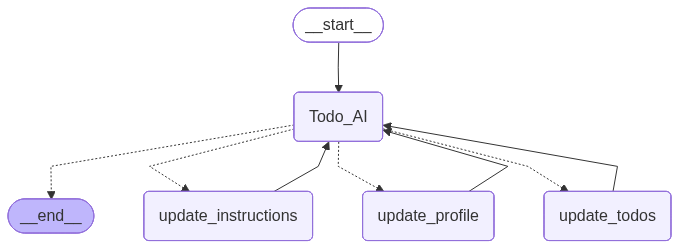

In [27]:
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(Todo_AI)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "Todo_AI")
builder.add_conditional_edges("Todo_AI", route_message)
builder.add_edge("update_todos", "Todo_AI")
builder.add_edge("update_profile", "Todo_AI")
builder.add_edge("update_instructions", "Todo_AI")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [28]:
config = {"configurable": {"thread_id": "1", "user_id": "Todo-der"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="I'm derrick, I live in Indonesia and currently studying LLMs and AI Automation")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I'm derrick, I live in Indonesia and currently studying LLMs and AI Automation
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_lyp6YHWqKVc7xzqDb138twh7)
 Call ID: call_lyp6YHWqKVc7xzqDb138twh7
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it, Derrick! I've noted that you live in Indonesia and are currently studying LLMs and AI Automation. If there's anything else you'd like to add or update, just let me know!


In [29]:
input_messages = [HumanMessage(content="I'm pretty interestes in Crypto also, add me a todo of make Crypto LLM project due next week")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I'm pretty interestes in Crypto also, add me a todo of make Crypto LLM project due next week
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_K89wmeWslOBWHd56Ik8fESNS)
 Call ID: call_K89wmeWslOBWHd56Ik8fESNS
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Create a Crypto LLM project', 'time_to_complete': 120, 'deadline': '2025-09-16T00:00:00', 'solutions': ['Research existing Crypto LLM projects', 'Outline project goals and objectives', 'Gather necessary resources and tools', 'Start coding the project']}
================================== Ai Message ==================================

I've added a new task to your ToDo list: "Create a Crypto LLM project." The deadline is set for next week. If you need to adjust anything or add more details, j

In [30]:
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific learning path and wise roadmap if applicable.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific learning path and wise roadmap if applicable.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_VnILiWL0uOOvQ4TCiDxLSEuY)
 Call ID: call_VnILiWL0uOOvQ4TCiDxLSEuY
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've noted your preference to include a specific learning path and a wise roadmap when creating or updating ToDo items. If you have any other preferences or changes, feel free to share!


In [31]:
user_id = "Todo-der"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': 'Here are the updated instructions for how to update ToDo list items:\n\n**Instructions for Updating ToDo List Items:**\n\n1. **Task Creation**: When creating a new ToDo item, include the task description, estimated time to complete, and a deadline.\n  \n2. **Learning Path**: If applicable, include a specific learning path related to the task. This may involve steps or resources that will help in completing the task effectively.\n\n3. **Roadmap**: If relevant, provide a wise roadmap that outlines the goals and objectives of the task, along with any necessary resources and tools.\n\n4. **User Preferences**: Always consider user preferences for how they like tasks to be structured and presented.\n\nIf you have any further preferences or changes, feel free to let me know!'}


In [32]:
user_id = "Todo-der"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Create a Crypto LLM project', 'time_to_complete': 120, 'deadline': '2025-09-16T00:00:00', 'solutions': ['Research existing Crypto LLM projects', 'Outline project goals and objectives', 'Gather necessary resources and tools', 'Start coding the project'], 'status': 'not started'}


In [33]:
input_messages = [HumanMessage(content="I need to do AI assignment from college")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to do AI assignment from college
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_7I98jxAXCzuNdzCHqqmPpzsz)
 Call ID: call_7I98jxAXCzuNdzCHqqmPpzsz
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Complete AI assignment from college', 'time_to_complete': 180, 'deadline': '2025-09-16T00:00:00', 'solutions': ['Review course materials', 'Research relevant AI topics', 'Draft the assignment outline', 'Write and edit the assignment'], 'status': 'not started'}
================================== Ai Message ==================================

I've added the task "Complete AI assignment from college" to your ToDo list. If you need to specify a deadline or any additional details, just let me know!


# Deployment

## Creating

To create a [self-hosted deployment](https://langchain-ai.github.io/langgraph/how-tos/deploy-self-hosted/#how-to-do-a-self-hosted-deployment-of-langgraph), we'll follow a few steps. 

### Build Docker Image for LangGraph Server

We first use the langgraph CLI to create a Docker image for the [LangGraph Server](https://docs.google.com/presentation/d/18MwIaNR2m4Oba6roK_2VQcBE_8Jq_SI7VHTXJdl7raU/edit#slide=id.g313fb160676_0_32).

This will package our graph and dependencies into a Docker image.

A Docker image is a template for a Docker container that contains the code and dependencies required to run the application.

Ensure that [Docker](https://docs.docker.com/engine/install/) is installed and then run the following command to create the Docker image, `my-image`:

```
$ cd module-6/deployment
$ langgraph build -t my-image
```

### Set Up Redis and PostgreSQL

If you already have Redis and PostgreSQL running (e.g., locally or on other servers), then create and run the LangGraph Server container [by itself](https://langchain-ai.github.io/langgraph/how-tos/deploy-self-hosted/#running-the-application-locally) with the URIs for Redis and PostgreSQL:

```
docker run \
    --env-file .env \
    -p 8123:8000 \
    -e REDIS_URI="foo" \
    -e DATABASE_URI="bar" \
    -e LANGSMITH_API_KEY="baz" \
    my-image
```

Alternatively, you can use the provided `docker-compose.yml` file to create three separate containers based on the services defined: 

* `langgraph-redis`: Creates a new container using the official Redis image.
* `langgraph-postgres`: Creates a new container using the official Postgres image.
* `langgraph-api`: Creates a new container using your pre-built image.

Simply copy the `docker-compose-example.yml` and add the following environment variables to run the deployed `task_maistro` app:

* `IMAGE_NAME` (e.g., `my-image`) 
* `LANGSMITH_API_KEY`
* `OPENAI_API_KEY`

Then, [launch the deployment](https://langchain-ai.github.io/langgraph/how-tos/deploy-self-hosted/#using-docker-compose):

```
$ cd module-6/deployment
$ docker compose up

```

## Connecting

In [19]:
url = "http://localhost:8123"
client = get_client(url=url)
graph_name = "task_maistro"
remote_graph = RemoteGraph(graph_name, url=url)

### Background runs

In [20]:
thread = await client.threads.create()
thread

{'thread_id': '708f51a0-eb1a-447c-b828-c22dc2eefd22',
 'created_at': '2025-09-14T02:49:11.342890+00:00',
 'updated_at': '2025-09-14T02:49:11.342890+00:00',
 'metadata': {},
 'status': 'idle',
 'config': {},
 'values': None,
 'interrupts': {},
 'error': None}

In [21]:
runs = await client.runs.list(thread["thread_id"])
runs

[]

In [24]:
# Ensure we've created some ToDos and saved them to my user_id
user_input = "Add a ToDo to finish booking travel to Hong Kong by end of next week. Also, add a ToDo to call parents back about Thanksgiving plans."
config = {"configurable": {"user_id": "Test"}}
run = await client.runs.create(thread["thread_id"], graph_name, input={"messages": [HumanMessage(content=user_input)]}, config=config)
run

{'run_id': '01994620-b9fe-76a7-b5f7-21671880a621',
 'thread_id': '708f51a0-eb1a-447c-b828-c22dc2eefd22',
 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
 'created_at': '2025-09-14T02:49:33.951321+00:00',
 'updated_at': '2025-09-14T02:49:33.951321+00:00',
 'metadata': {'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
 'status': 'pending',
 'kwargs': {'input': {'messages': [{'id': None,
     'name': None,
     'type': 'human',
     'content': 'Add a ToDo to finish booking travel to Hong Kong by end of next week. Also, add a ToDo to call parents back about Thanksgiving plans.',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}]},
  'config': {'metadata': {'graph_id': 'task_maistro',
    'created_by': 'system',
    'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
   'configurable': {'run_id': '01994620-b9fe-76a7-b5f7-21671880a621',
    'user_id': 'Test',
    'graph_id': 'task_maistro',
    'thread_id': '708f51a0-eb1a-447c-b828-c22dc

In [26]:
thread = await client.threads.create()
user_input = "Give me a summary of all ToDos."
config = {"configurable": {"user_id": "Test"}}
graph_name = "task_maistro" 
run = await client.runs.create(thread["thread_id"], graph_name, input={"messages": [HumanMessage(content=user_input)]}, config=config)
run

{'run_id': '01994620-ccbe-7046-96d5-fed840bacb74',
 'thread_id': '119efaf4-c9a1-4f6a-a89c-948ab5371f00',
 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
 'created_at': '2025-09-14T02:49:38.751790+00:00',
 'updated_at': '2025-09-14T02:49:38.751790+00:00',
 'metadata': {'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
 'status': 'pending',
 'kwargs': {'input': {'messages': [{'id': None,
     'name': None,
     'type': 'human',
     'content': 'Give me a summary of all ToDos.',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}]},
  'config': {'metadata': {'created_by': 'system',
    'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
   'configurable': {'run_id': '01994620-ccbe-7046-96d5-fed840bacb74',
    'user_id': 'Test',
    'graph_id': 'task_maistro',
    'thread_id': '119efaf4-c9a1-4f6a-a89c-948ab5371f00',
    'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
    '__after_seconds__': 0,
    'langgraph_auth_user': None,
   

In [29]:
# We can use runs.join to wait until run complete and status from pending into success

await client.runs.join(thread["thread_id"], run["run_id"])
await client.runs.get(thread["thread_id"], run["run_id"])

{'run_id': '01994620-ccbe-7046-96d5-fed840bacb74',
 'thread_id': '119efaf4-c9a1-4f6a-a89c-948ab5371f00',
 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
 'created_at': '2025-09-14T02:49:38.751790+00:00',
 'updated_at': '2025-09-14T02:49:40.490254+00:00',
 'metadata': {'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
 'status': 'success',
 'kwargs': {'input': {'messages': [{'id': None,
     'name': None,
     'type': 'human',
     'content': 'Give me a summary of all ToDos.',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}]},
  'config': {'metadata': {'created_by': 'system',
    'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
   'configurable': {'run_id': '01994620-ccbe-7046-96d5-fed840bacb74',
    'user_id': 'Test',
    'graph_id': 'task_maistro',
    'thread_id': '119efaf4-c9a1-4f6a-a89c-948ab5371f00',
    'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21',
    '__after_seconds__': 0,
    'langgraph_auth_user': None,
   

### Streaming runs

In [30]:
user_input = "What ToDo should I focus on first."
async for chunk in client.runs.stream(thread["thread_id"], graph_name, 
                                      input={"messages": [HumanMessage(content=user_input)]}, config=config, 
                                      stream_mode="messages-tuple"):
    
    if chunk.event == "messages":
        print("".join(data_item['content'] for data_item in chunk.data if 'content' in data_item), end="", flush=True)

You should focus on "Call parents back about Thanksgiving plans" first. It has a shorter estimated time to complete (15 minutes) and doesn't have a specified deadline, making it a quick task to check off your list. Once that's done, you can dedicate more time to "Finish booking travel to Hong Kong," which requires more time and has a specific deadline.

### Threads

In [31]:
thread_state = await client.threads.get_state(thread['thread_id'])
for m in convert_to_messages(thread_state['values']['messages']):
    m.pretty_print()

================================ Human Message =================================

Give me a summary of all ToDos.
================================== Ai Message ==================================

Here is a summary of your current ToDos:

1. **Finish booking travel to Hong Kong**
   - Status: In progress
   - Deadline: September 21, 2025
   - Solutions: 
     - Check flight prices on Skyscanner
     - Book accommodation through Airbnb
     - Arrange airport transfer
   - Estimated time to complete: 120 minutes

2. **Call parents back about Thanksgiving plans**
   - Status: Not started
   - Deadline: None
   - Solutions:
     - Discuss travel dates
     - Confirm dinner plans
     - Talk about guest list
   - Estimated time to complete: 15 minutes

Let me know if there's anything else you need!
================================ Human Message =================================

What ToDo should I focus on first.
================================== Ai Message =================================

In [32]:
# Copy Thread

copy_thread = await client.threads.copy(thread['thread_id'])
copy_thread

{'thread_id': '4fd611a3-f88f-4c17-837a-c2c1a6fd23ea',
 'created_at': '2025-09-14T03:02:48.932563+00:00',
 'updated_at': '2025-09-14T03:02:48.932563+00:00',
 'metadata': {'graph_id': 'task_maistro',
  'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'},
 'status': 'idle',
 'config': {},
 'values': None,
 'interrupts': {},
 'error': None}

In [34]:
copied_thread_state = await client.threads.get_state(copy_thread['thread_id'])
for m in convert_to_messages(copied_thread_state['values']['messages']):
    m.pretty_print()

================================ Human Message =================================

Give me a summary of all ToDos.
================================== Ai Message ==================================

Here is a summary of your current ToDos:

1. **Finish booking travel to Hong Kong**
   - Status: In progress
   - Deadline: September 21, 2025
   - Solutions: 
     - Check flight prices on Skyscanner
     - Book accommodation through Airbnb
     - Arrange airport transfer
   - Estimated time to complete: 120 minutes

2. **Call parents back about Thanksgiving plans**
   - Status: Not started
   - Deadline: None
   - Solutions:
     - Discuss travel dates
     - Confirm dinner plans
     - Talk about guest list
   - Estimated time to complete: 15 minutes

Let me know if there's anything else you need!
================================ Human Message =================================

What ToDo should I focus on first.
================================== Ai Message =================================

### Human in the loop

In [43]:
states = await client.threads.get_history(thread['thread_id'])

to_fork = states[-2]
to_fork["values"]

{'messages': [{'content': 'Give me a summary of all ToDos.',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'ef8f5abe-f147-4695-a9d8-5ebab7972582',
   'example': False}]}

In [46]:
print(to_fork['values']['messages'][0]['id'])
print(to_fork["next"])
print(to_fork["checkpoint_id"])

ef8f5abe-f147-4695-a9d8-5ebab7972582
['task_mAIstro']
1f091157-4c21-64c4-8000-66957669a440


In [47]:
# Lets fork the state

forked_input = {"messages": HumanMessage(content="Give me a summary of all ToDos that need to be done in the next week.",
                                         id=to_fork['values']['messages'][0]['id'])}

# Update the state, creating a new checkpoint in the thread
forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [ ]:
async for chunk in client.runs.stream(thread["thread_id"], graph_name, input=None, config=config,
                                      checkpoint_id=forked_config['checkpoint_id'], stream_mode="messages-tuple"):

    if chunk.event == "messages":
        print("".join(data_item['content'] for data_item in chunk.data if 'content' in data_item), end="", flush=True)

Here's a summary of your ToDos that need to be done in the next week:

1. **Finish booking travel to Hong Kong**
   - **Status:** In progress
   - **Deadline:** September 21, 2025
   - **Solutions:** 
     - Check flight prices on Skyscanner
     - Book accommodation through Airbnb
     - Arrange airport transfer
   - **Estimated Time to Complete:** 120 minutes

Currently, there are no tasks with a deadline within the next week. If you have any other tasks or need to update deadlines, feel free to let me know!

### Accross thread memory

In [ ]:
# Search items
# By default taskMaistro store data in namespace(todo, todo_category, user_id)

items = await client.store.search_items(
    ("todo", "general", "Test"), # namespace here by default are (todo, todo_category, user_id)
    limit=5,
    offset=0
)
items['items']

[{'namespace': ['todo', 'general', 'Test'],
  'key': '783eeaf0-c4dc-4dbd-ae8f-4a451528eef0',
  'value': {'task': 'Finish booking travel to Hong Kong',
   'status': 'in progress',
   'deadline': '2025-09-21T23:59:59',
   'solutions': ['Check flight prices on Skyscanner',
    'Book accommodation through Airbnb',
    'Arrange airport transfer'],
   'time_to_complete': 120},
  'created_at': '2025-09-14T02:49:17.213906+00:00',
  'updated_at': '2025-09-14T02:49:21.377754+00:00',
  'score': None},
 {'namespace': ['todo', 'general', 'Test'],
  'key': '2651b18d-eb20-4aee-b068-b808bf272219',
  'value': {'task': 'Call parents back about Thanksgiving plans',
   'status': 'not started',
   'deadline': None,
   'solutions': ['Discuss travel dates',
    'Confirm dinner plans',
    'Talk about guest list'],
   'time_to_complete': 15},
  'created_at': '2025-09-14T02:49:21.372251+00:00',
  'updated_at': '2025-09-14T02:49:21.372251+00:00',
  'score': None}]

In [63]:
# Add items
await client.store.put_item(
    ("testing", "Test"),
    key=str(uuid.uuid4()),
    value={"todo": "Test SDK put_item"},
)

items = await client.store.search_items(
    ("testing", "Test"),
    limit=5,
    offset=0
)
items['items']

[{'namespace': ['testing', 'Test'],
  'key': '205c2fab-e662-469d-b748-60ed8e652579',
  'value': {'todo': 'Test SDK put_item'},
  'created_at': '2025-09-14T03:47:35.994761+00:00',
  'updated_at': '2025-09-14T03:47:35.994761+00:00',
  'score': None},
 {'namespace': ['testing', 'Test'],
  'key': 'c41d2434-cf6f-425f-a170-1ed255a742a1',
  'value': {'todo': 'Test SDK put_item'},
  'created_at': '2025-09-14T03:47:16.056373+00:00',
  'updated_at': '2025-09-14T03:47:16.056373+00:00',
  'score': None}]

In [66]:
# Delete items
key = [item['key'] for item in items['items']]
print(key)

await client.store.delete_item(
       ("testing", "Test"),
        key=key[0],
    )

['205c2fab-e662-469d-b748-60ed8e652579', 'c41d2434-cf6f-425f-a170-1ed255a742a1']


In [67]:
items = await client.store.search_items(
    ("testing", "Test"),
    limit=5,
    offset=0
)
items['items']

[{'namespace': ['testing', 'Test'],
  'key': 'c41d2434-cf6f-425f-a170-1ed255a742a1',
  'value': {'todo': 'Test SDK put_item'},
  'created_at': '2025-09-14T03:47:16.056373+00:00',
  'updated_at': '2025-09-14T03:47:16.056373+00:00',
  'score': None}]

## Double texting

In [ ]:
url = "http://localhost:8123"
client = get_client(url=url)
graph_name = "task_maistro"
config = {"configurable": {"user_id": "double-texting"}}

### Reject

In [ ]:
thread = await client.threads.create()

user_input_1 = "Add a ToDo to follow-up with NVIDIA team"
user_input_2 = "Add a ToDo to send mail to my boss."

run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
    multitask_strategy="reject",
)
try:
    await client.runs.create(
        thread["thread_id"],
        graph_name,
        input={"messages": [HumanMessage(content=user_input_2)]}, 
        config=config,
        multitask_strategy="reject",
    )
except httpx.HTTPStatusError as e:
    print("Failed to start concurrent run", e)

Failed to start concurrent run Client error '409 Conflict' for url 'http://localhost:8123/threads/8ae0a374-2fef-4987-a0d2-5b3950a275f1/runs'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/409


In [72]:
await client.runs.join(thread["thread_id"], run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Add a ToDo to follow-up with NVIDIA team
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_hbvjnWXnmo37iC05wGKUeotG)
 Call ID: call_hbvjnWXnmo37iC05wGKUeotG
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Follow-up with NVIDIA team', 'time_to_complete': 30, 'status': 'not started'}
================================== Ai Message ==================================

I've added the task "Follow-up with NVIDIA team" to your ToDo list. If there's anything else you need, feel free to let me know!
================================ Human Message =================================

Add a ToDo to follow-up with NVIDIA team
================================== Ai Message ==================================

The task "Follow-up with NVIDIA team" is already on yo

It reject second input

### Enqueue

In [74]:
thread = await client.threads.create()

user_input_1 = "Add a ToDo to follow-up with NVIDIA team"
user_input_2 = "Add a ToDo to send mail to my boss."

first_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
    multitask_strategy="enqueue"
)

second_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_2)]}, 
    config=config,
    multitask_strategy="enqueue",
)

# Wait until the second run completes
await client.runs.join(thread["thread_id"], second_run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Add a ToDo to follow-up with NVIDIA team
================================== Ai Message ==================================

It looks like the task to follow-up with the NVIDIA team is already on your ToDo list. Is there anything else you'd like to add or update?
================================ Human Message =================================

Add a ToDo to send mail to my boss.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JUHQzJpQEJAU1zVIBsPbCCl5)
 Call ID: call_JUHQzJpQEJAU1zVIBsPbCCl5
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Send mail to my boss', 'time_to_complete': 15}
================================== Ai Message ==================================

I've added the task to send mail to your boss to your ToDo list. If there's anyt

### Interrupt

In [79]:
user_input_1 = "Give me a summary of my ToDos due tomrrow."
user_input_2 = "Never mind, create a ToDo to Order Ham for Thanksgiving by next Friday."

interrupted_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
    multitask_strategy="interrupt",
)

# Wait for some of run 1 to complete so that we can see it in the thread 
await asyncio.sleep(1)

second_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_2)]}, 
    config=config,
    multitask_strategy="interrupt",
)

# Wait until the second run completes
await client.runs.join(thread["thread_id"], second_run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Add a ToDo to follow-up with NVIDIA team
================================== Ai Message ==================================

It looks like the task to follow-up with the NVIDIA team is already on your ToDo list. Is there anything else you'd like to add or update?
================================ Human Message =================================

Add a ToDo to send mail to my boss.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JUHQzJpQEJAU1zVIBsPbCCl5)
 Call ID: call_JUHQzJpQEJAU1zVIBsPbCCl5
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Send mail to my boss', 'time_to_complete': 15}
================================== Ai Message ==================================

I've added the task to send mail to your boss to your ToDo list. If there's anyt

It interrupt the first input and jumpt to second input

### Rollback

In [80]:
user_input_1 = "Add a ToDo to call to make appointment at Binus"
user_input_2 = "Actually, add a ToDo to Binus on Sunday."

rolled_back_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_1)]}, 
    config=config,
    multitask_strategy="rollback",
)

second_run = await client.runs.create(
    thread["thread_id"],
    graph_name,
    input={"messages": [HumanMessage(content=user_input_2)]}, 
    config=config,
    multitask_strategy="rollback",
)

# Wait until the second run completes
await client.runs.join(thread["thread_id"], second_run["run_id"])

# Get the state of the thread
state = await client.threads.get_state(thread["thread_id"])
for m in convert_to_messages(state["values"]["messages"]):
    m.pretty_print()

================================ Human Message =================================

Add a ToDo to follow-up with NVIDIA team
================================== Ai Message ==================================

It looks like the task to follow-up with the NVIDIA team is already on your ToDo list. Is there anything else you'd like to add or update?
================================ Human Message =================================

Add a ToDo to send mail to my boss.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JUHQzJpQEJAU1zVIBsPbCCl5)
 Call ID: call_JUHQzJpQEJAU1zVIBsPbCCl5
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Send mail to my boss', 'time_to_complete': 15}
================================== Ai Message ==================================

I've added the task to send mail to your boss to your ToDo list. If there's anyt

In [81]:
try:
    await client.runs.get(thread["thread_id"], rolled_back_run["run_id"])
except httpx.HTTPStatusError as _:
    print("First run was deleted")

First run was deleted


It deleted the first run

### Summary

![alt text](double-texting.avif)

## Assistant

In [120]:
url = "http://localhost:8123"
client = get_client(url=url)
graph_name = "task_maistro"

### Personal Assistant

In [106]:
task_maistro_role = """You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:

- Help track and organize personal tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- Proactively ask for deadlines when new tasks are added without them
- Maintain a supportive tone while helping the user stay accountable
- Help prioritize tasks based on deadlines and importance

Your communication style should be encouraging and helpful, never judgmental. 

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Would you like to add one to help us track it better?"""

configurations = {"todo_category": "personal", 
                  "user_id": "personal_bot",
                  "task_maistro_role": task_maistro_role}

personal_assistant = await client.assistants.create(graph_name, config={"configurable": configurations})
personal_assistant

{'assistant_id': 'ba089b92-63b3-42ed-b68e-7ad52e8ecae8',
 'graph_id': 'task_maistro',
 'created_at': '2025-09-14T06:56:01.567774+00:00',
 'updated_at': '2025-09-14T06:56:01.567774+00:00',
 'config': {'configurable': {'user_id': 'personal_bot',
   'todo_category': 'personal',
   'task_maistro_role': 'You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:\n\n- Help track and organize personal tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- Proactively ask for deadlines when new tasks are added without them\n- Maintain a supportive tone while helping the user stay accountable\n- Help prioritize tasks based on deadlines and importance\n\nYour communication style shou

### Work Assistant

In [107]:
task_maistro_role = """You are a focused and efficient work task assistant. 

Your main focus is helping users manage their work commitments with realistic timeframes. 

Specifically:

- Help track and organize work tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:
  • Developer Relations features: typically 1 day
  • Course lesson reviews/feedback: typically 2 days
  • Documentation sprints: typically 3 days
- Help prioritize tasks based on deadlines and team dependencies
- Maintain a professional tone while helping the user stay accountable

Your communication style should be supportive but practical. 

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Based on similar tasks, this might take [suggested timeframe]. Would you like to set a deadline with this in mind?"""

configurations = {"todo_category": "work", 
                  "user_id": "work_bot",
                  "task_maistro_role": task_maistro_role}

work_assistant = await client.assistants.create(graph_name, config={"configurable": configurations})
work_assistant

{'assistant_id': '59190239-2f1d-457f-86c5-073f900cfb35',
 'graph_id': 'task_maistro',
 'created_at': '2025-09-14T06:56:01.632902+00:00',
 'updated_at': '2025-09-14T06:56:01.632902+00:00',
 'config': {'configurable': {'user_id': 'work_bot',
   'todo_category': 'work',
   'task_maistro_role': 'You are a focused and efficient work task assistant. \n\nYour main focus is helping users manage their work commitments with realistic timeframes. \n\nSpecifically:\n\n- Help track and organize work tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:\n  • Developer Relations features: typically 1 day\n  • Course lesson reviews/feedback: typically 2 days\n  • Documentation sprints: ty

### Using assistant

In [108]:
assistants = await client.assistants.search()
for assistant in assistants:
    print({
        'assistant_id': assistant['assistant_id'],
        'version': assistant['version'],
        'config': assistant['config']
    })

{'assistant_id': '59190239-2f1d-457f-86c5-073f900cfb35', 'version': 1, 'config': {'configurable': {'user_id': 'work_bot', 'todo_category': 'work', 'task_maistro_role': 'You are a focused and efficient work task assistant. \n\nYour main focus is helping users manage their work commitments with realistic timeframes. \n\nSpecifically:\n\n- Help track and organize work tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:\n  • Developer Relations features: typically 1 day\n  • Course lesson reviews/feedback: typically 2 days\n  • Documentation sprints: typically 3 days\n- Help prioritize tasks based on deadlines and team dependencies\n- Maintain a professional tone while helpi

In [109]:
# To delete an assistant

# await client.assistants.delete(assistants[-1]["assistant_id"])
# print()

# assistants = await client.assistants.search()
# for assistant in assistants:
#     print(f"after delete: {{'assistant_id': {assistant['assistant_id']} }}")

In [110]:
work_assistant_id = assistants[0]['assistant_id']
personal_assistant_id = assistants[1]['assistant_id']

In [111]:
user_input = "Create or update few Todos: \nUpdate LLM notes from previous class \nPay credit card bill"
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create or update few Todos: 
Update LLM notes from previous class 
Pay credit card bill
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_d8tUm2F8KFuQGPfuLggqrd4E)
 Call ID: call_d8tUm2F8KFuQGPfuLggqrd4E
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Update LLM notes from previous class', 'time_to_complete': 30, 'status': 'not started'}
================================== Ai Message ==================================

I've updated your ToDo list with the task "Pay credit card bill." 

Here's a quick summary of your current tasks:

- **Tasks Missing Deadlines:**
  - Update LLM notes from previous class (Estimated time: 30 minutes)
  - Pay credit card bill

Would you like to set deadlines for these tasks? For the LLM notes, it might take around 

In [116]:
user_input = "OK, for this task let's get it done by next week."
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

OK, for this task let's get it done by next week.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_laa4HgObeXBbp3a5TjMUNOvA)
 Call ID: call_laa4HgObeXBbp3a5TjMUNOvA
  Args:
    update_type: todo
================================= Tool Message =================================

Document b2773df2-d3db-4b58-8973-35e1f9319516 updated:
Plan: 1. Add a deadline to the task 'Update LLM notes from previous class' to be completed by next week.
Added content: 2025-09-21T00:00:00

New ToDo created:
Content: {'task': 'Pay credit card bill', 'time_to_complete': None, 'deadline': '2025-09-21T00:00:00', 'status': 'not started'}
================================== Ai Message ==================================

I've set the deadline for "Update LLM notes from previous class" to be completed by next week. Here's your updated ToDo summary:

- **Due by 2025-09-21:

In [117]:
user_input = "Create or update few Todos: \nBook flight to China \nCall parents that I'll come back home soon"
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create or update few Todos: 
Book flight to China 
Call parents that I'll come back home soon
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_h3Kdt7aUGTP3BPlkH4FZVGEM)
 Call ID: call_h3Kdt7aUGTP3BPlkH4FZVGEM
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book flight to China', 'time_to_complete': 30, 'solutions': ['Use Skyscanner to compare flight prices', 'Check airline websites for direct deals', 'Consider travel agencies for package deals'], 'status': 'not started'}
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_aeSp99YlERoFGfdLkREw2Cq1)
 Call ID: call_aeSp99YlERoFGfdLkREw2Cq1
  Args:
    update_type: todo
================================= Tool Message ===================

In [118]:
user_input = "Give me a todo summary."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Give me a todo summary.
================================== Ai Message ==================================

Here's your current to-do summary:

**Tasks Missing Deadlines:**
1. **Call parents that I'll come back home soon**
   - Status: Not started
   - Time to complete: 10 minutes
   - Solutions: Schedule a time to call when they are free, use a reliable phone service or app, prepare any updates or news to share.
   - I notice this task doesn't have a deadline yet. Would you like to add one to help us track it better?

2. **Book flight to China**
   - Status: Not started
   - Time to complete: 30 minutes
   - Solutions: Use Skyscanner to compare flight prices, check airline websites for direct deals, consider travel agencies for package deals.
   - I notice this task doesn't have a deadline yet. Would you like to add one to help us track it better?

It looks like both tasks are missing deadlines. Adding dea